# __VeMo Description:__

VeMo is a framework designed to model vehicle states (ax, ay, yaw-rate) based on pilot inputs (throttle, brake, steering angle, gear) and past states.

VeMo consists of two underlying models:

- One based on a Deep Neural Network containing relationships extracted from the single-track kinematic model [0].  
- One based on the Sparse Identification of Non-linear Dynamics method with control (SINDy-C) introduced in Brunton et al. [1].

These models are merged using dynamic weights based on the delta between the two. This allows for the extraction of a strongly nonlinear model from the neural part and a coupled model based on ODEs identified by SINDy, ensuring coherence in the dynamic response of the final output.


__Requirements:__
   
> python: 3.10.12  
keras: 2.15.0  
keras_self_attention: 0.51.0  
matplotlib: 3.7.1  
numpy: 1.25.2  
pandas: 2.0.3  
pysindy: 1.7.5  
scipy: 1.11.4  
sklearn: 1.4.2  
tensorflow: 2.15.0  

__References:__  
>[0]: Schramm, D., Hiller, M., Bardini, R. (2014). Single Track Models. Vehicle Dynamics. Springer, Berlin, Heidelberg.  
https://doi.org/10.1007/978-3-540-36045-2_10  
[1]: Brunton, S. L., Proctor, J. L., Kutz, J. N. (2016). Sparse  
Identification of Nonlinear Dynamics with Control (SINDYc).  
https://doi.org/10.1016/j.ifacol.2016.10.249 , https://github.com/dynamicslab/pysindy  
[2]: State-Space Rapresentation.  
https://en.wikipedia.org/wiki/State-space_representation


###__0. VeMo Net__

VeMo Net is the neural part of the framewor, this is a GRU-based neural network with physics information built-in, following the single-track kinematic model.
>  

As said, inspiration is drawn from a single-track kinematic model to determine vx, vy, and yaw rate.

\begin{align*}
\dot{x} &= v \cdot \cos(\beta) \\
\dot{y} &= v \cdot \sin(\beta) \\
\dot{\theta} &= \frac{v \cdot \tan(\delta_w) \cdot \cos(\beta)}{L} \\
\beta &= \arctan\left(\frac{l_r \cdot \tan(\delta_w)}{L}\right)
\end{align*}

These are derived to obtain ax and ay as well, thus extending the network's internal state. Clearly, since velocity is not directly available from the input, a correlation is sought with v through gear and with wheels delta through steering wheel delta, also scalar coefficient will be removed because network will infer scaling coefficients by mean its weights.  

\begin{align*}
\dot{x}_e &= gear \cdot \cos(\beta_e) \\
\dot{y}_e &= gear \cdot \sin(\beta_e) \\
\dot{\theta}_e &= gear \cdot \tan(\delta_s) \cdot \cos(\beta_e) \\
\beta_e &= \delta_s
\end{align*}

In addition sine activation functions, in the last layer, are used, as they are zero-centered and more significant for the physics of the signals involved compared to hyperbolic tangent activation.






###__1. VeMo SINDy__

The modeling process with SINDy aims to obtain a system of discrete and linear ODEs. This model is extracted as the best model among 200 identified systems. The models follow the structure:  
\begin{align*}
\mathbf{x}(k+1) = \mathbf{A}(k)\mathbf{x}(k) + \mathbf{B}(k)\mathbf{u}(k)
\end{align*}


Where:   

$\mathbf{x}(\cdot)$ is called the "state vector",      
$\mathbf{x}(t) \in \mathbb{R}^n$;     
$\mathbf{u}(\cdot)$ is called the "input (or control) vector",  
$\mathbf{u}(t) \in \mathbb{R}^p$;

$\mathbf{A}(\cdot)$ is the "state (or system) matrix",     
$\text{dim}[\mathbf{A}(\cdot)] = n \times n$;  
$\mathbf{B}(\cdot)$ is the "input matrix",     
$\text{dim}[\mathbf{B}(\cdot)] = n \times p$;  


For the continous version of the system above [1][2].  

The choice was made to model the SINDy system with the constraint of linearity, in the system and in the functions, so that in the face of a less accurate model, it is possible for the user to easily obtain the characteristic eigenvalues of the system, directly from the matrices above, thus obtaining macro-indications on the stability of the system under consideration.




---



# __Example Usage:__

In [ ]:
# @title __0. Import Dependencies__

locals().clear()
globals().clear()

!pip install keras_self_attention

!rm -rf pysindy
!git clone https://github.com/dynamicslab/pysindy.git
!cd pysindy/pysindy/.
!ls
!pip install pysindy

!cd ..
!ls
#!rm -rf VeMo_Core
#!git clone https://github.com/GirolamoOddo/VeMo.git
#!cp VeMo/VeMo_Core.py /.
#!cp VeMo/Test_Imola-mclaren.csv /.
#!cp VeMo/Train_Suzuka-mclaren.csv /.

from VeMo_Core import VeMo
################################################################################
## VeMo DEPENDENCIES:
#python: 3.10.12
#keras: 2.15.0
#keras_self_attention: 0.51.0
#matplotlib: 3.7.1
#numpy: 1.25.2
#pandas: 2.0.3
#pysindy: 1.7.5
#scipy: 1.11.4
#sklearn: 1.4.2
#tensorflow: 2.15.0
################################################################################

import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt

tf.keras.backend.clear_session()

seed=89
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)
init=tf.keras.initializers.GlorotNormal(seed=seed)
keras.utils.set_random_seed(seed=seed)


  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=fb93bc34dff8d08eeb55109c10f24a46d8ca79c5543535c44de4815e6f7b56e6
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention
Cloning into 'pysindy'...
remote: Enumerating objects: 12534, done.
remote: Counting objects: 100% (3205/3205), done.
remote: Compressing objects: 100% (1242/1242), done.
remote: Total 12534 (delta 1993), reused 1963 (delta 1963), pack-reused 9329
Receiving objects: 100% (12534/12534), 905.33 MiB | 23.33 MiB/s, done.
Resolving deltas: 100% (8134/8134), done.
Updating files: 100% (498/498), done.
pysindy  sample_data  Test_Imola-mclaren.csv  Train_Suzuka-mclaren.csv	VeMo_Core.py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 2.9 MB/s eta 0:00:00
pysindy  sample_data  Test_Imola-mclaren.csv  Train_Suzuka-mclaren.c

In [ ]:
# @title __1. Preprocessing Settings Params__

csv_file_path_TRAIN = '/content/Train_Suzuka-mclaren.csv'
csv_file_path_TEST  = '/content/Test_Imola-mclaren.csv'

# columns can change name, but keeping this naming is suggested
columns_to_import = ['THROTTLE', 'BRAKE', 'STEERING', 'GEAR',
                     'GLONG', 'GLAT', 'ROTY']

# scaling can't change the keys name but only the scaling value associated
scaling_factors = { 'THROTTLE': 100.0, 'BRAKE': 100.0, 'STEERING': 200.0, 'GEAR': 6.0,
                    'GLONG': 3.0, 'GLAT': 3.0, 'ROTY': 60.0}



from VeMo: DATA LOADED CORRECTLY!


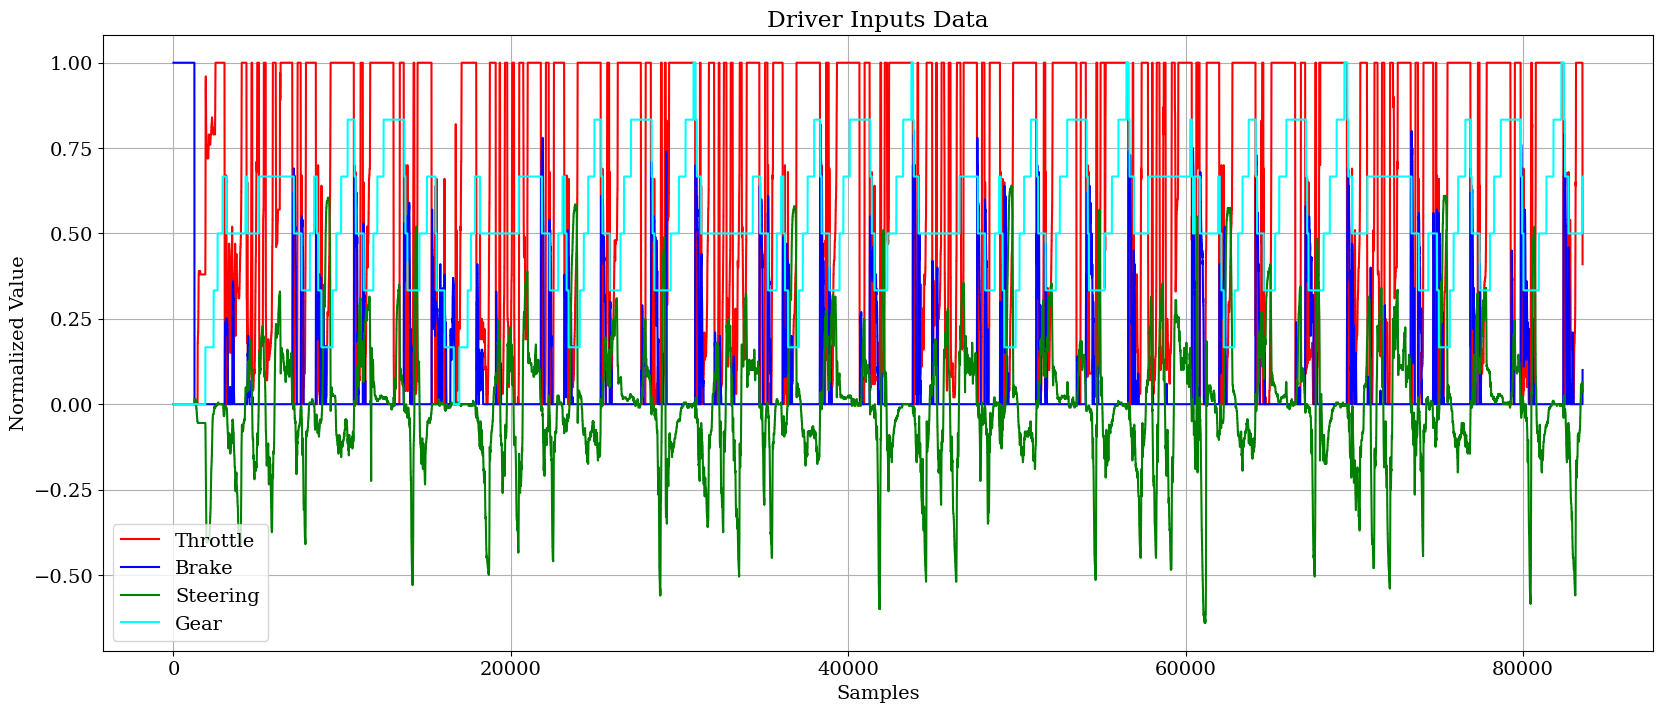

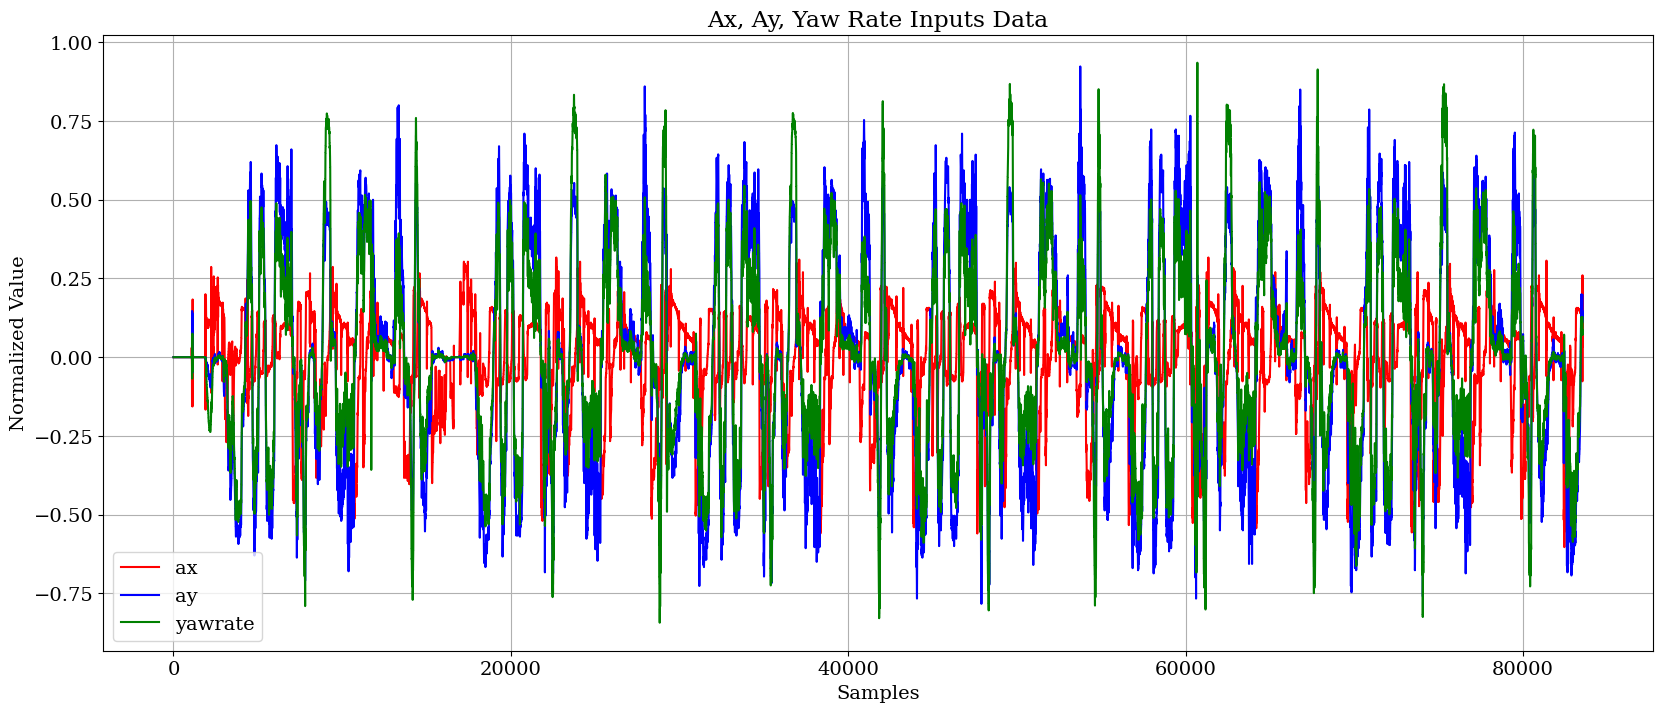


from VeMo: DATA LOADED CORRECTLY!


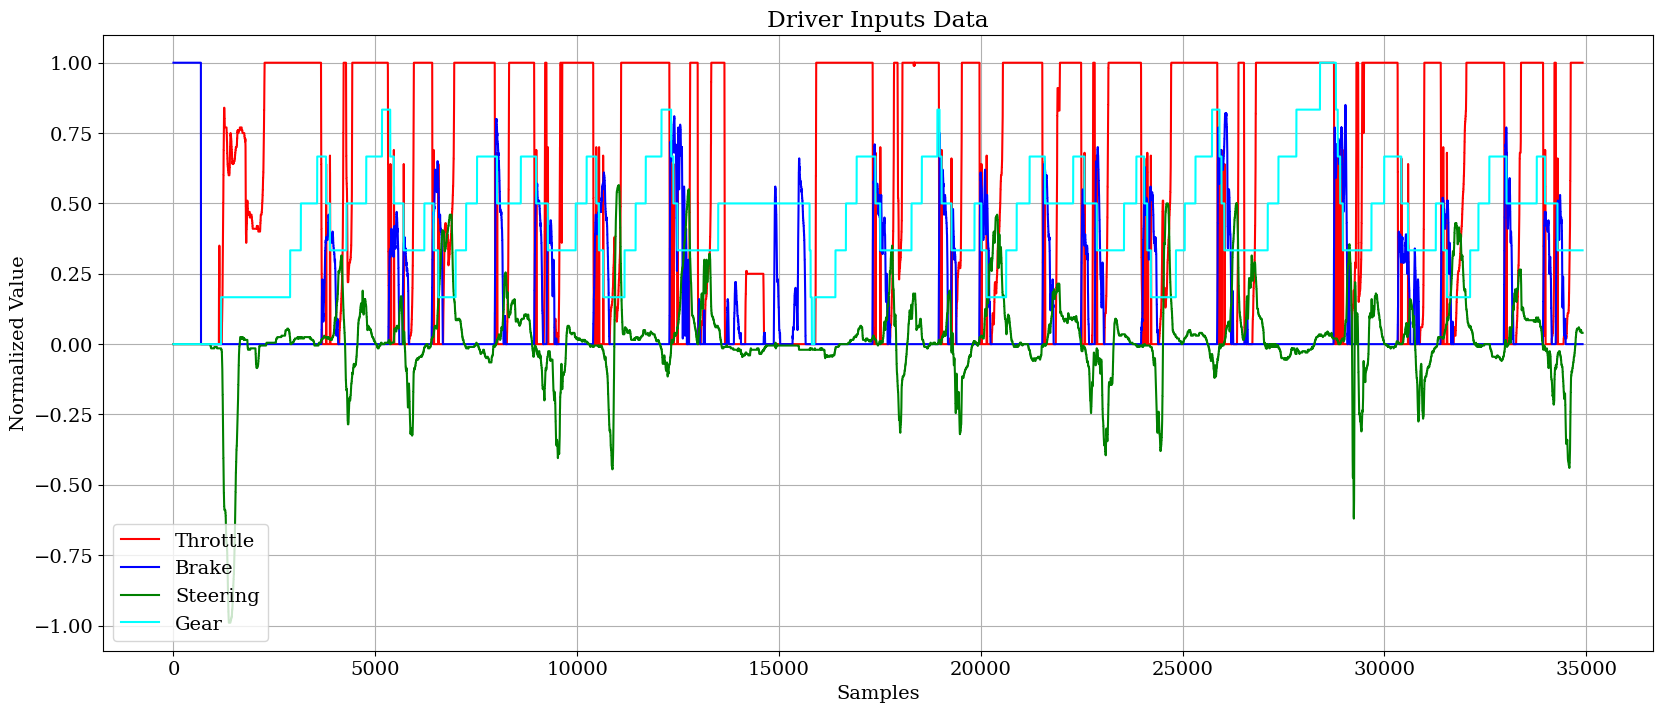

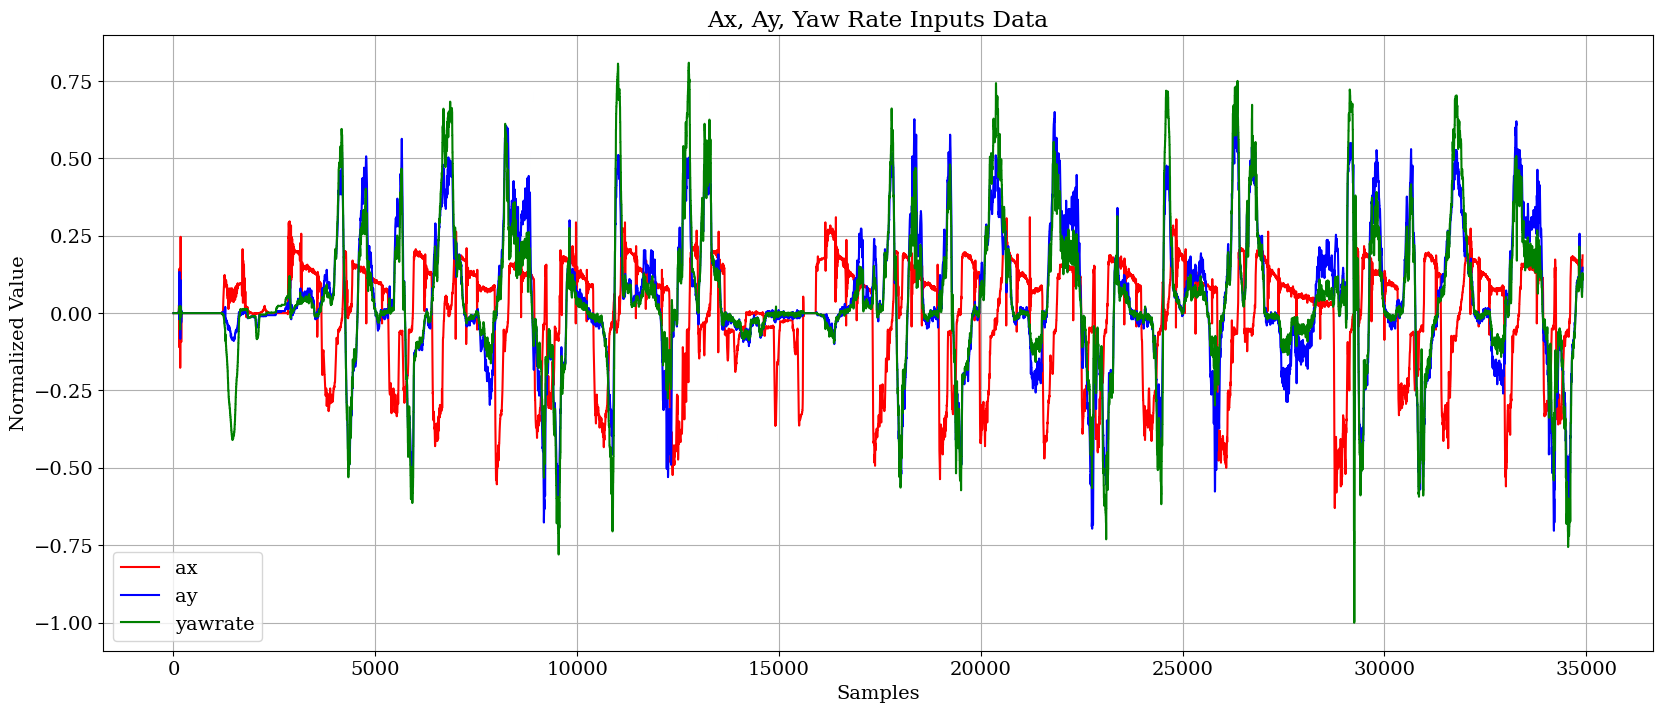

(83541, 7)

from VeMo: DATA PREPARATION DONE!
X Shape (83491, 50, 4)
y Shape (83491, 3)

from VeMo: DATA PREPARATION DONE!
X Shape (34862, 50, 4)
y Shape (34862, 3)


In [ ]:
# @title __2. Preperocessing using VeMo Methods__

vemo = VeMo() #initializing VeMo
#vemo.n_steps = 50 # past instants that the VeMo_Net must consider [-]
#vemo.sampling_rate = 100.0 # sampling frequency of signals (driver's inputs and acceleration) [Hz]

# data_processor takes selected columns from csv and apply the scaling factor
data_TRAIN = vemo.data_preprocessor(csv_file_path= csv_file_path_TRAIN,
                                    columns_to_import= columns_to_import, scaling_factors= scaling_factors)

data_TEST  = vemo.data_preprocessor(csv_file_path= csv_file_path_TEST,
                                    columns_to_import= columns_to_import, scaling_factors= scaling_factors)

data_TRAIN = data_TRAIN[:][:]
print(np.shape(data_TRAIN))

# data_reshaper reformat the data to be suitable for recurrents layers in the VeMo_Net
X_TRAIN, y_TRAIN = vemo.data_reshaper(series= data_TRAIN)

X_TEST,  y_TEST  = vemo.data_reshaper(series= data_TEST)


VeMo_SINDy

---------------------------------------------------------------
Model for data fraction: 0.1
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 2.0170e+00 ... 1.4308e-01 ...         15 ... 2.1600e+00
         1 ... 2.0119e+00 ... 1.4354e-01 ...         15 ... 2.1554e+00
(ax)[k+1] = 0.994 ax[k] + 0.004 ay[k] + -0.009 yawrate[k] + 0.002 throttle[k] + 0.004 steering[k] + -0.002 gear[k]
(ay)[k+1] = 0.006 ax[k] + 0.976 ay[k] + 0.036 yawrate[k] + -0.009 steering[k]
(yawrate)[k+1] = 0.006 ax[k] + 0.013 ay[k] + 0.970 yawrate[k] + 0.021 steering[k] + -0.001 gear[k]


Matrix A:
[[ 0.99358216  0.00411299 -0.00858465]
 [ 0.00633163  0.97592057  0.03577777]
 [ 0.0057818   0.01303663  0.97017221]]


Eigenvalues of A:
+0.994+0.002j
+0.994-0.002j
+0.952+0j


Matrix B:
[[ 0.00192438  0.          0.00377907 -0.00218756]
 [ 0.          0.         -0.00920214  0.        ]
 [ 0.          0.          0.02104727 -0.00100406]]


---------

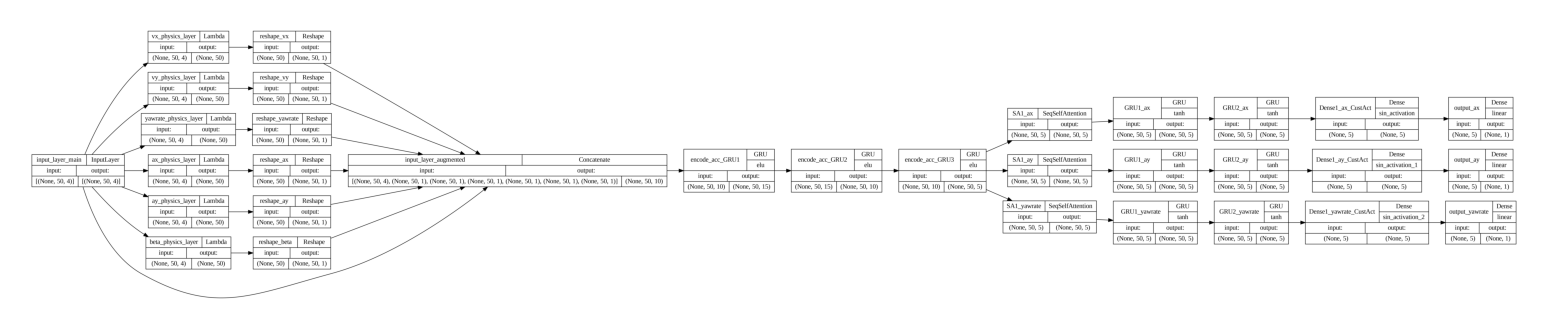

Epoch 1/4
1305/1305 [==============================] - 345s 252ms/step - loss: 0.1045 - output_ax_loss: 0.0271 - output_ay_loss: 0.0421 - output_yawrate_loss: 0.0353 - val_loss: 0.0770 - val_output_ax_loss: 0.0253 - val_output_ay_loss: 0.0299 - val_output_yawrate_loss: 0.0219
Epoch 2/4
1305/1305 [==============================] - 333s 255ms/step - loss: 0.0639 - output_ax_loss: 0.0155 - output_ay_loss: 0.0264 - output_yawrate_loss: 0.0221 - val_loss: 0.0618 - val_output_ax_loss: 0.0178 - val_output_ay_loss: 0.0258 - val_output_yawrate_loss: 0.0181
Epoch 3/4
1305/1305 [==============================] - 320s 246ms/step - loss: 0.0545 - output_ax_loss: 0.0126 - output_ay_loss: 0.0231 - output_yawrate_loss: 0.0189 - val_loss: 0.0553 - val_output_ax_loss: 0.0171 - val_output_ay_loss: 0.0220 - val_output_yawrate_loss: 0.0162
Epoch 4/4
1305/1305 [==============================] - 320s 245ms/step - loss: 0.0522 - output_ax_loss: 0.0117 - output_ay_loss: 0.0224 - output_yawrate_loss: 0.0180 - v

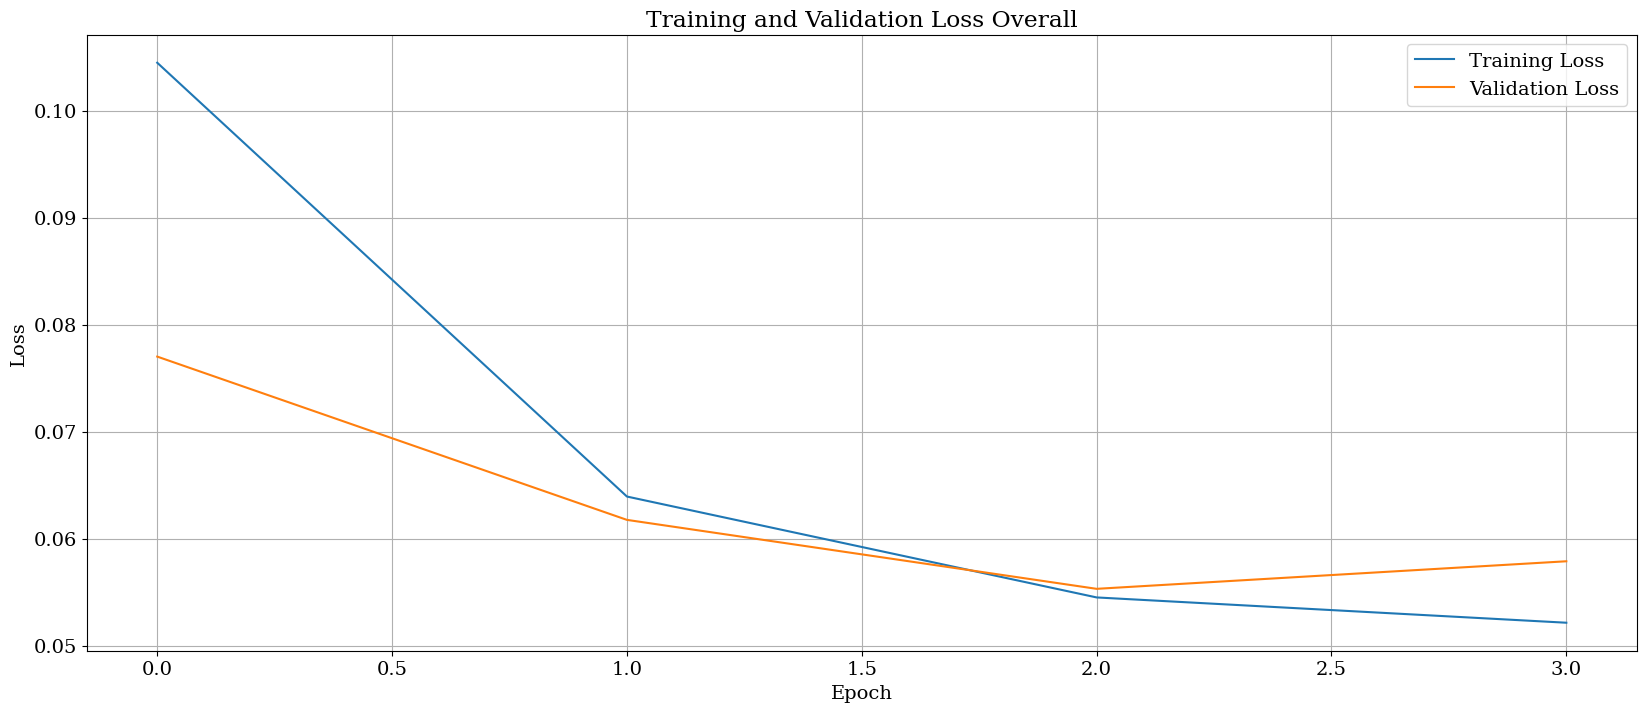

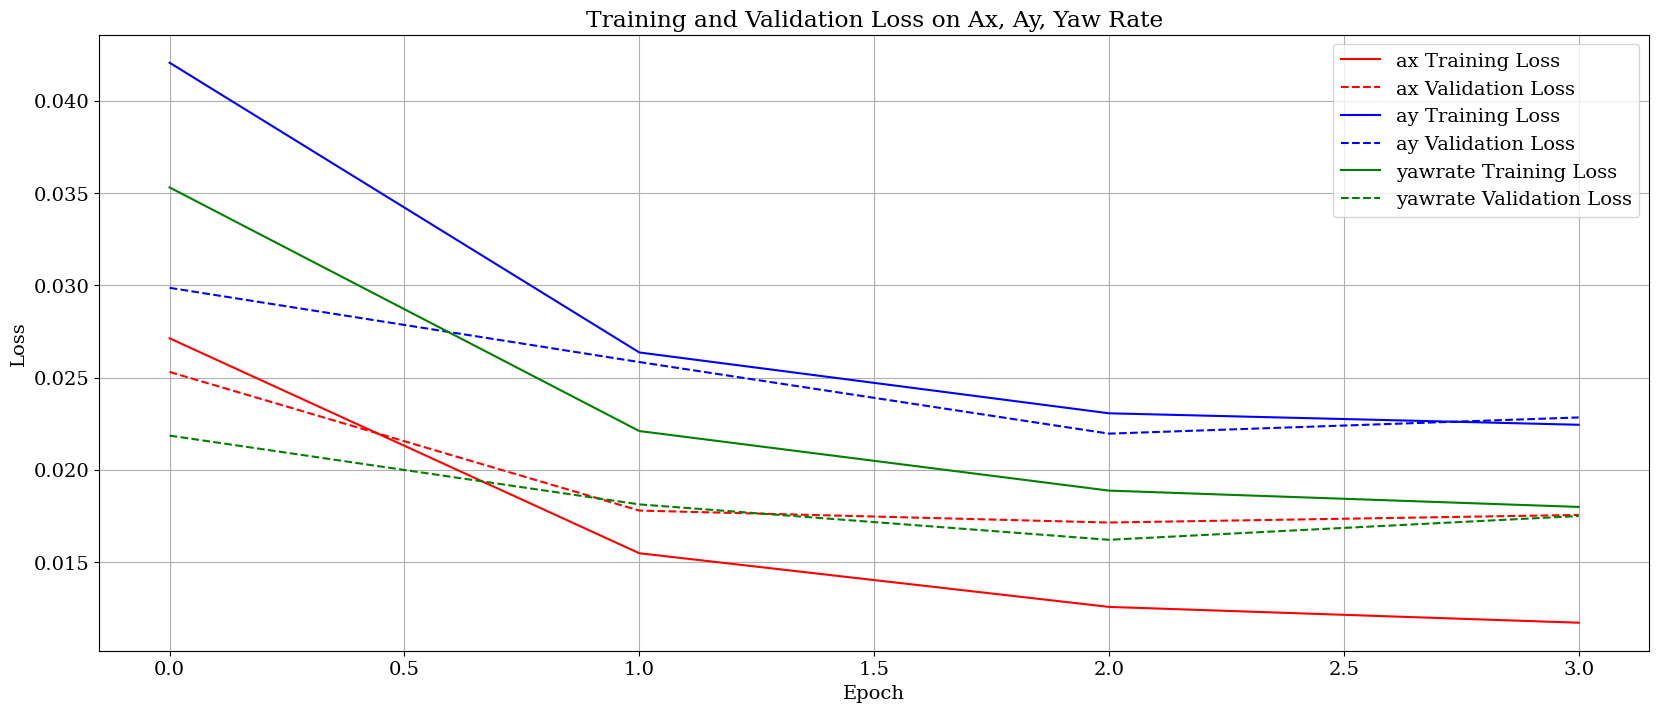

In [ ]:
# @title __3. Build and Train VeMo Models (SINDy & NN)__

print('VeMo_SINDy'), print()
vemo.sindy_modeller(data_TRAIN) # sindy_modeller generate the VeMo_SINDy model as VeMo_SINDy.pkl file
print()

input_train =  np.array(X_TRAIN)
target_train = np.array(y_TRAIN)

input_validation =  np.array(X_TEST)
target_validation = np.array(y_TEST)

print('VeMo_Net'), print()
vemo.build_model() # this function compile the VeMo_Net from tensorflow API structure
vemo.train(input_train, target_train, input_validation, target_validation, epochs=4) # this function train the VeMo_Net w/ the setted epochs
print()


1090/1090 [==============================] - 56s 49ms/step
(3, 34862, 1)
(34862, 3)

from VeMo: y_prdicted signal order: [ax, ay, yawrate]

from VeMo: Comparation w/ SINDy model done!
(34862, 3)
(34862, 3)
NaN values in signal1: 0
NaN values in signal2: 0
NaN values in signal1: 0
NaN values in signal2: 0
NaN values in signal1: 0
NaN values in signal2: 0

-----------------------------------------------------------------
Median Error Yaw Rate NN: 0.4832204765712572
Mean Error Yaw Rate NN: 2.1139450264538335
RMSE Yaw Rate NN: 0.12620195259059744


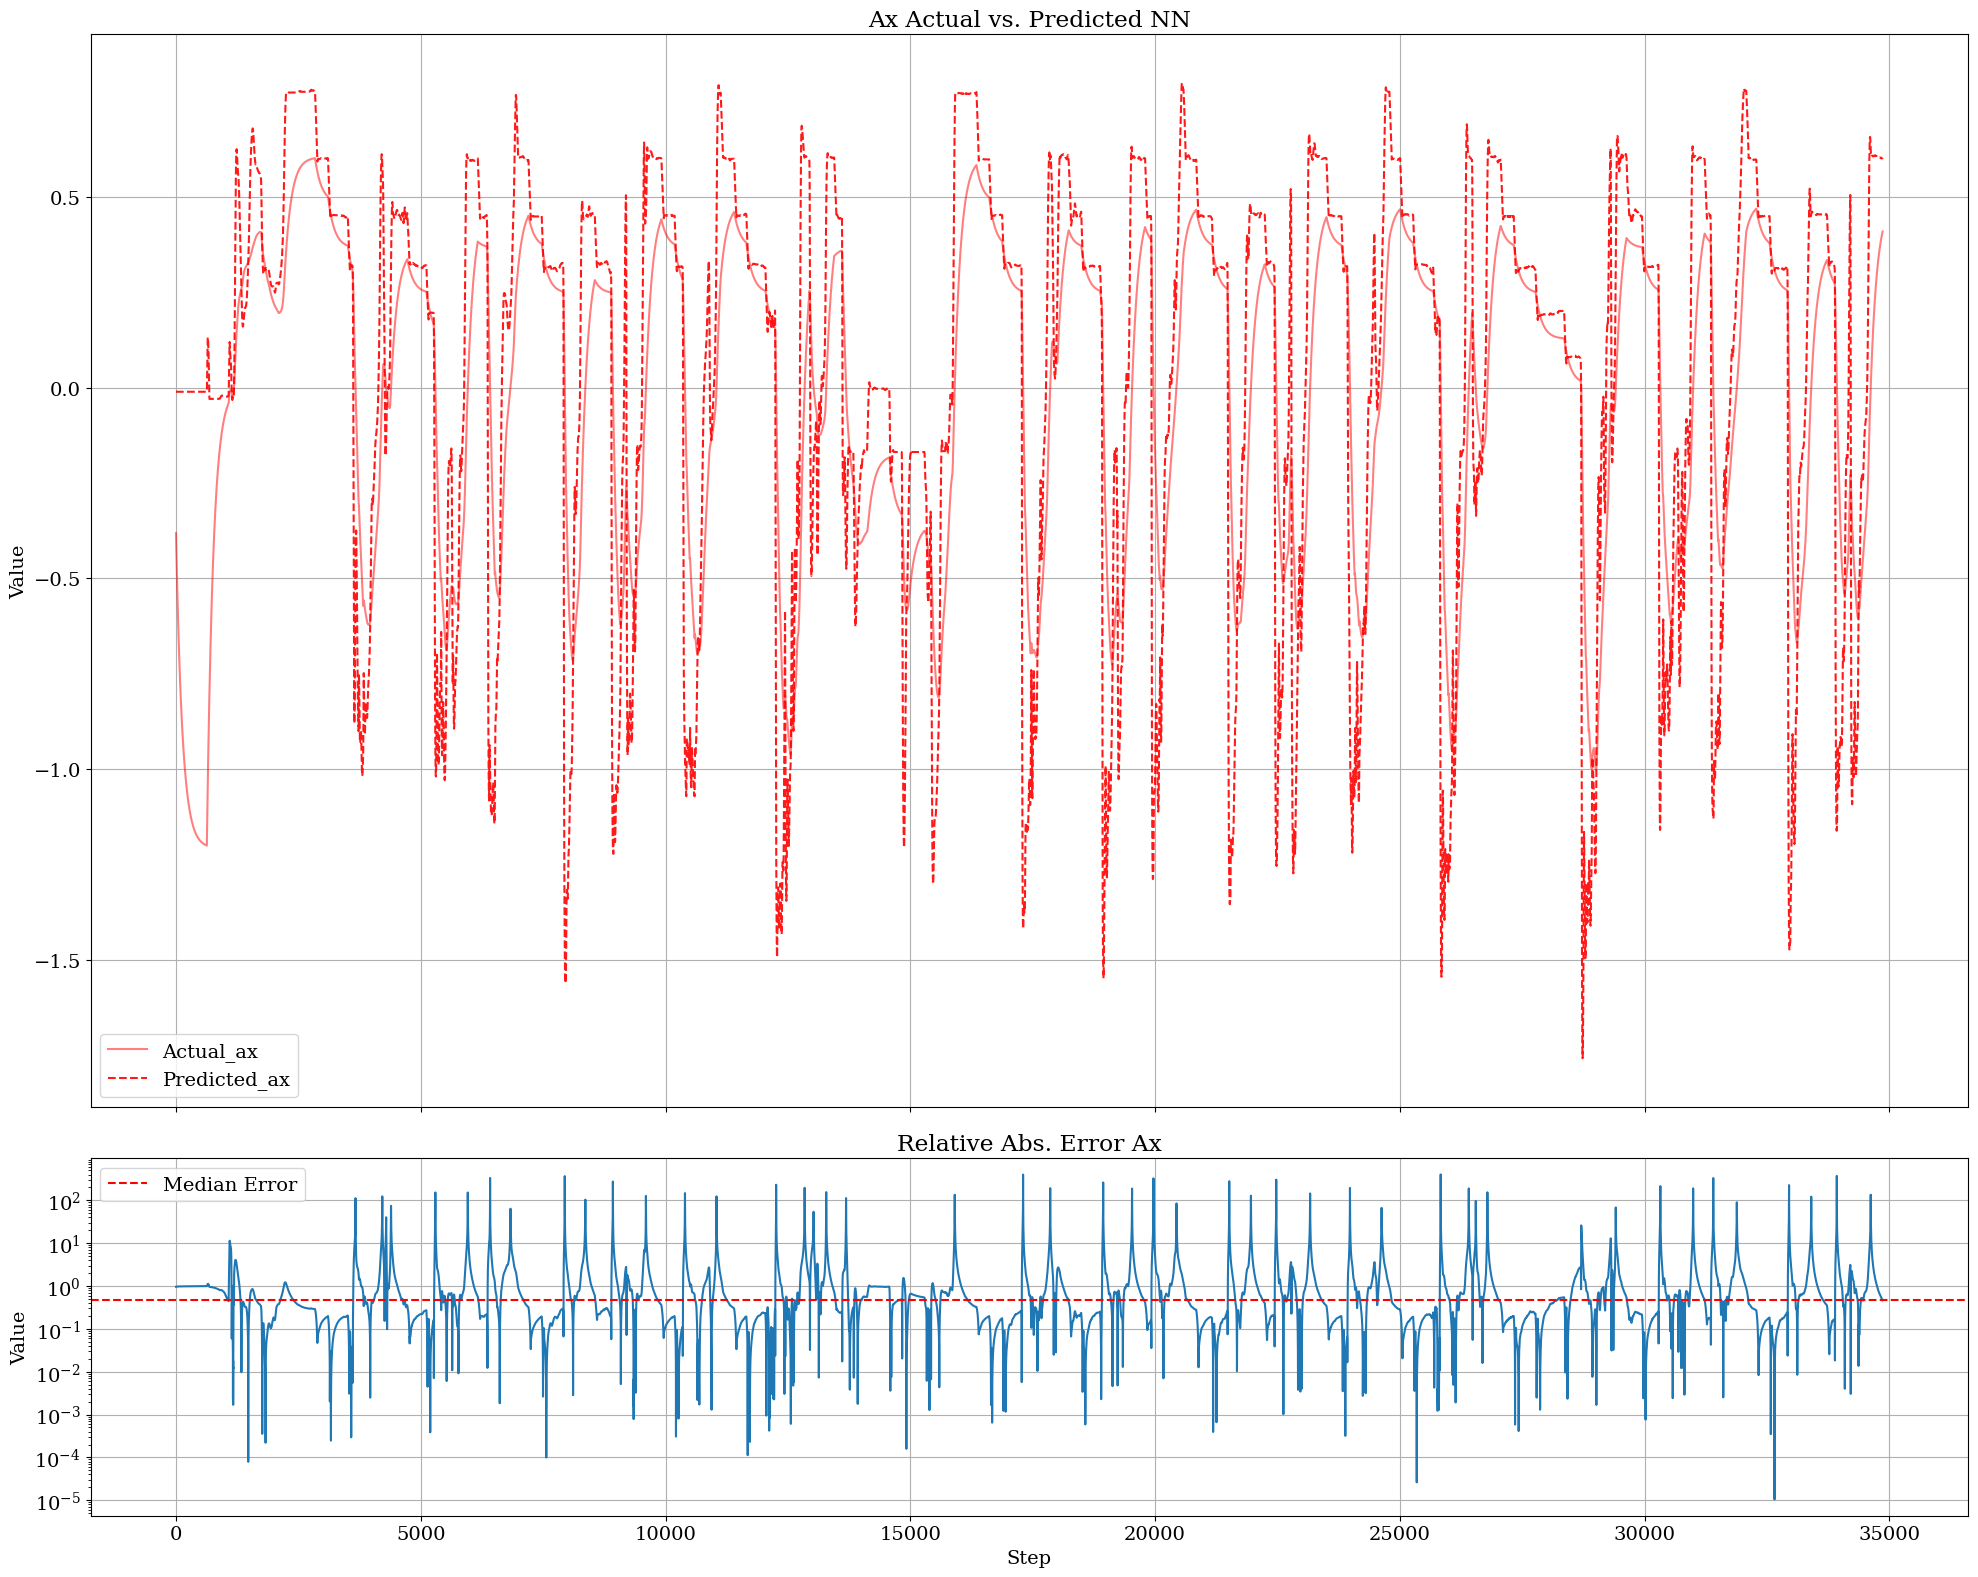


-----------------------------------------------------------------
Median Error Yaw Rate NN: 1.3293702835537342
Mean Error Yaw Rate NN: 4.383601424030593
RMSE Yaw Rate NN: 0.23818642758303557


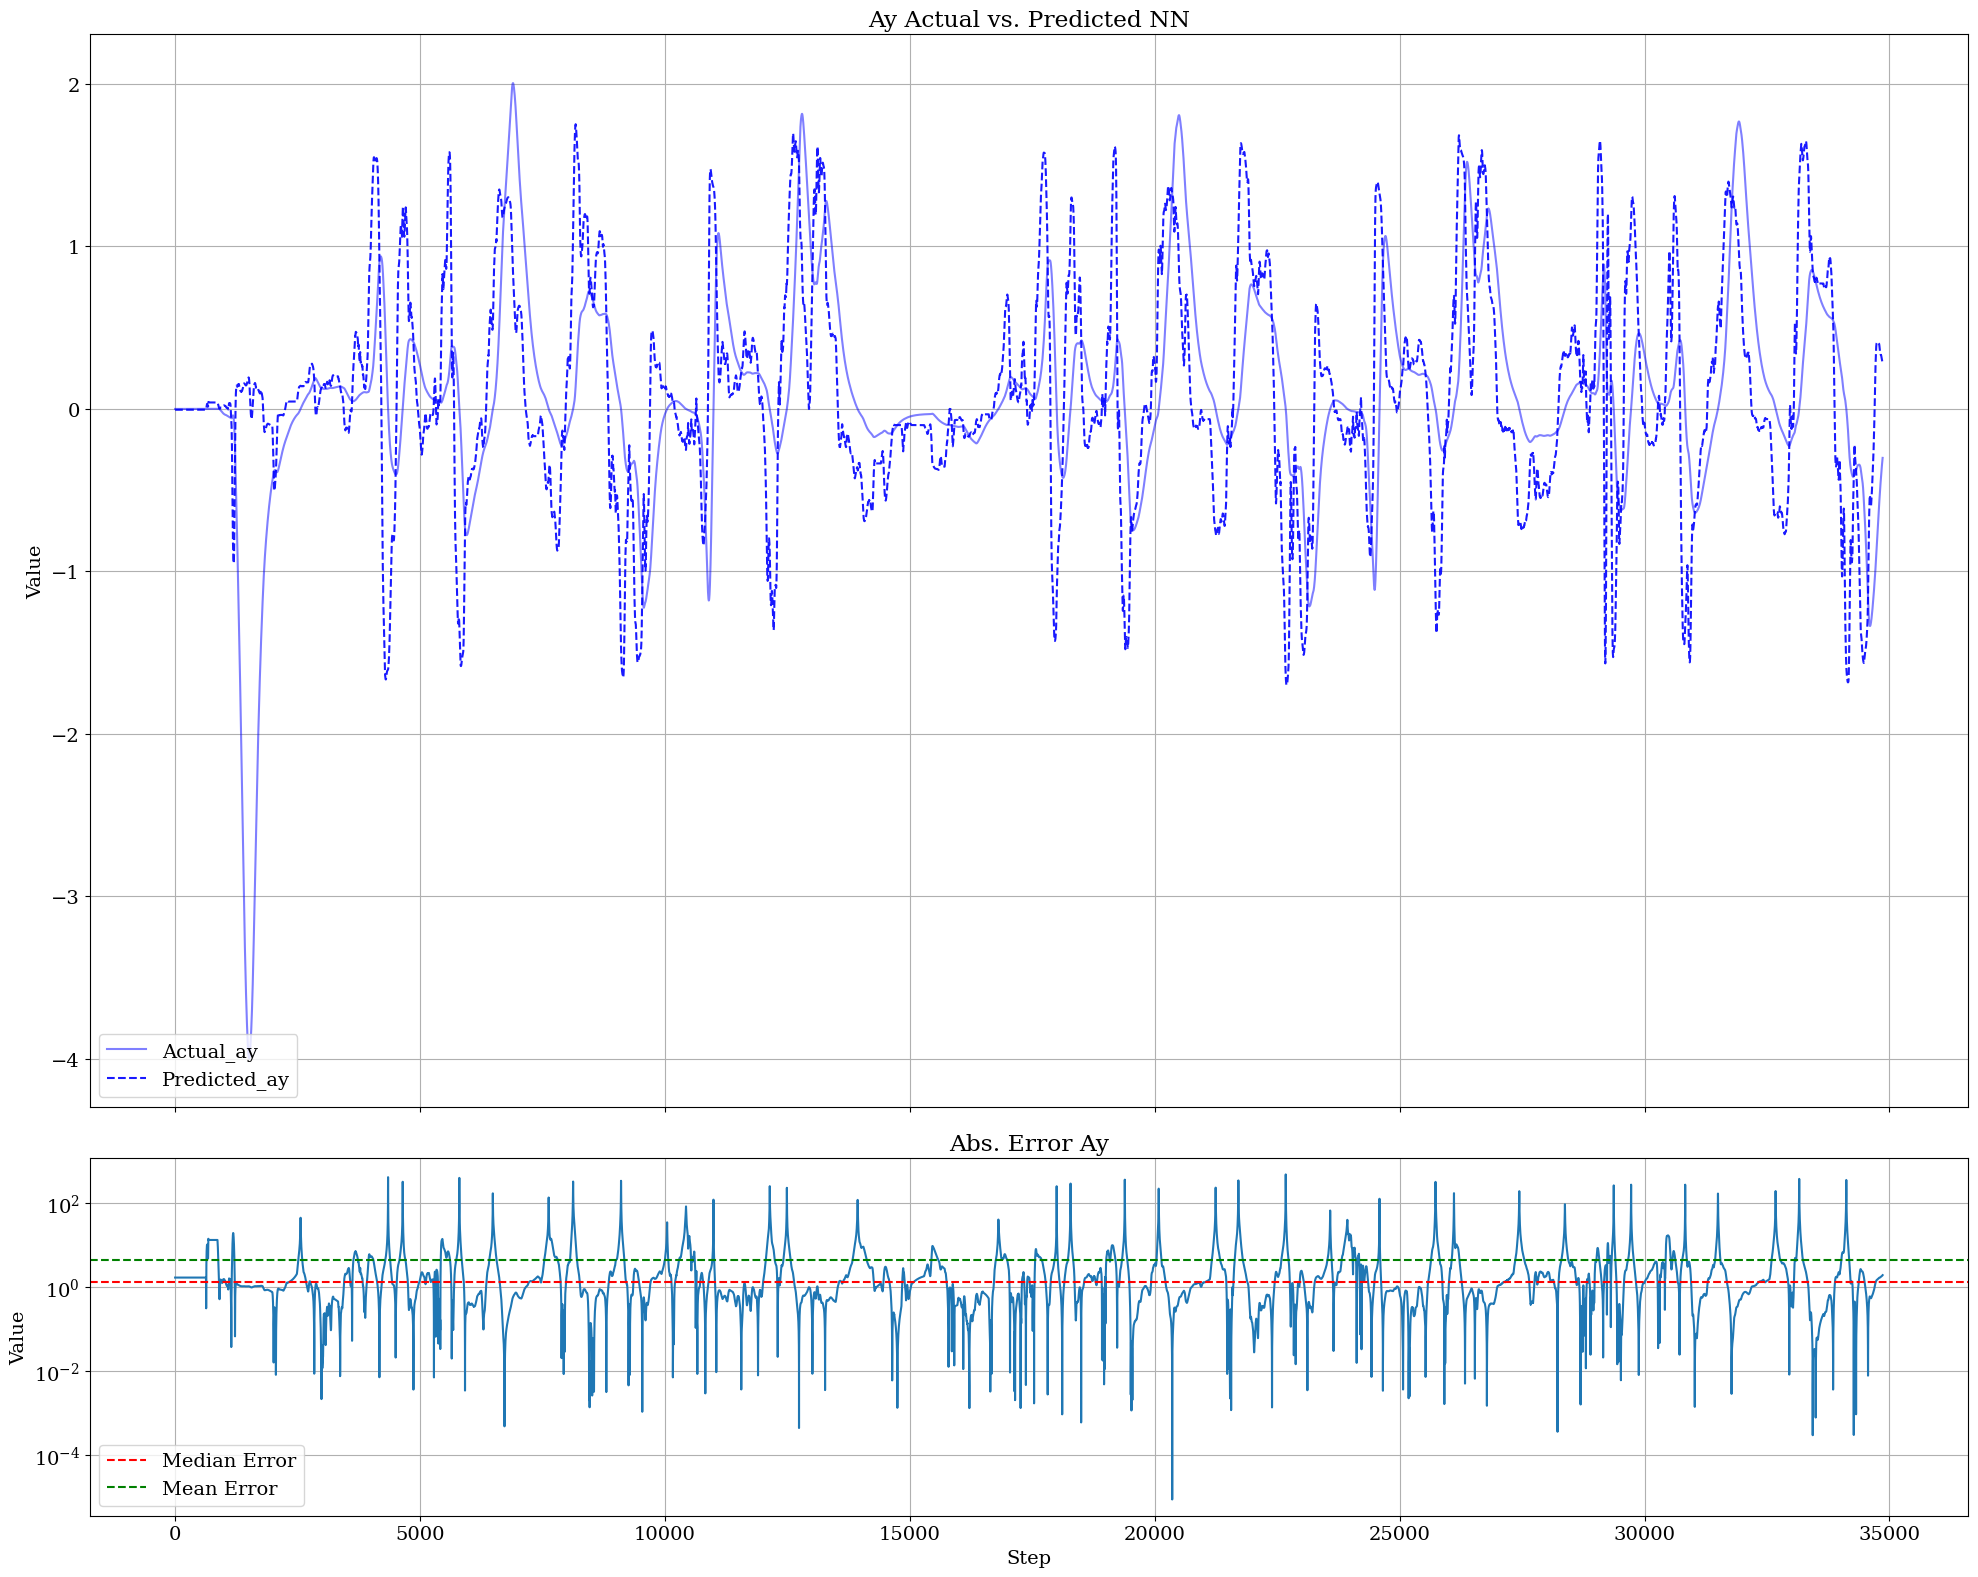


-----------------------------------------------------------------
Median Error Yaw Rate NN: 0.7252806114417578
Mean Error Yaw Rate NN: 1.7718668513710076
RMSE Yaw Rate NN: 0.11757060785790205


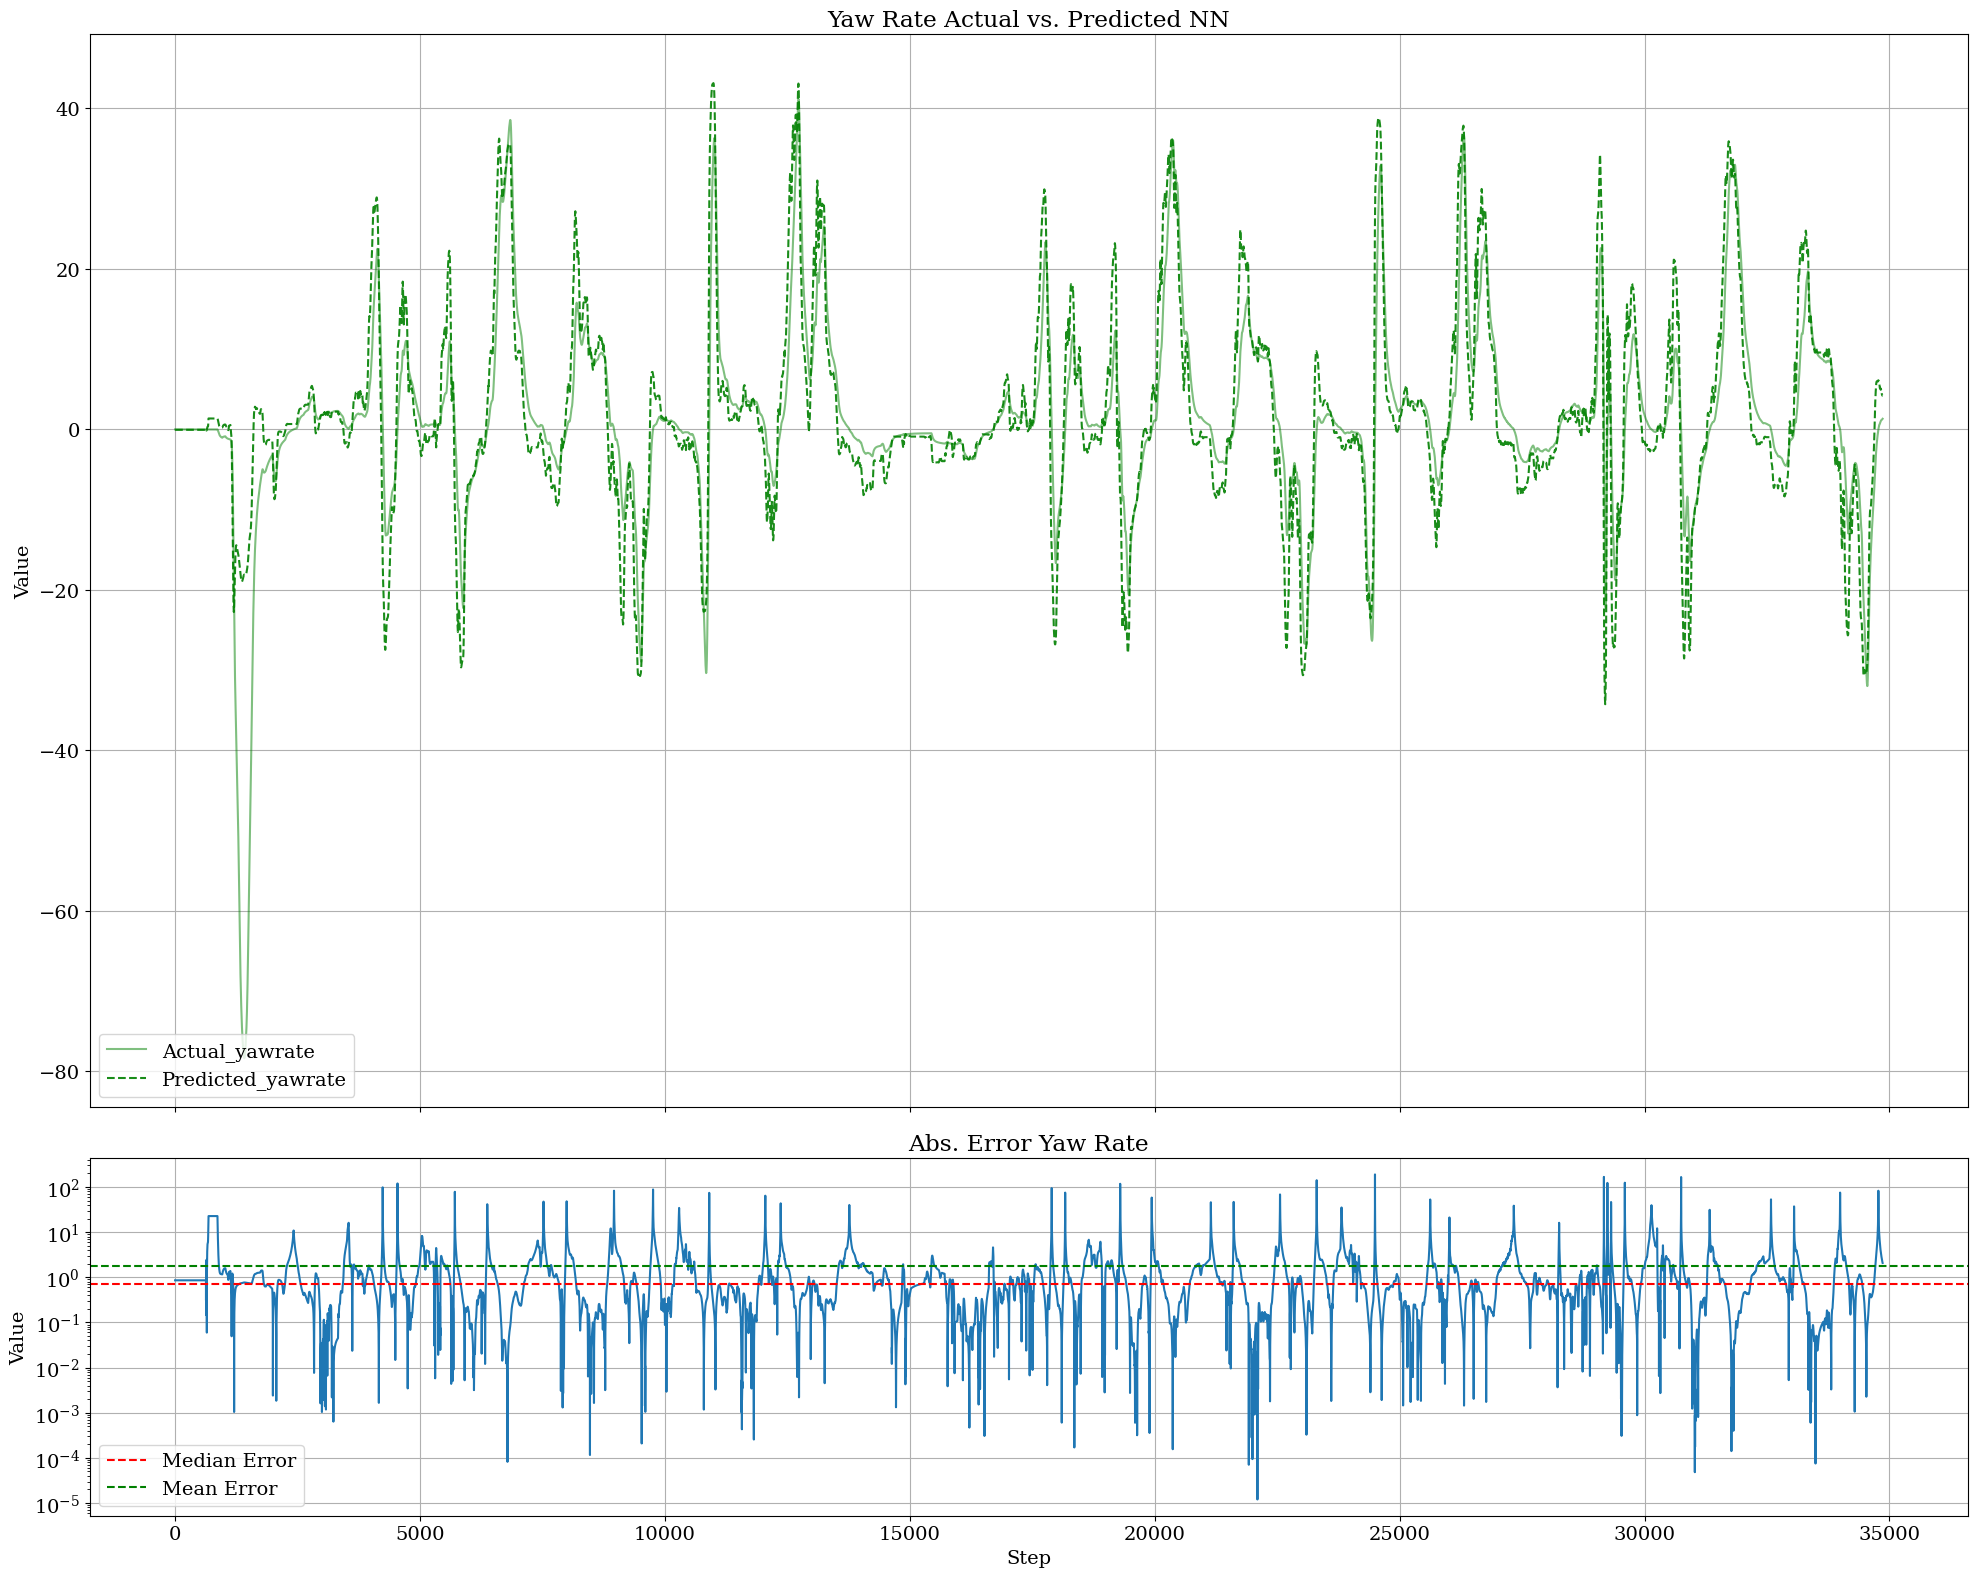


-----------------------------------------------------------------
Median Error Ax SINDy: 0.526637165207786
Mean Error Ax SINDy: 2.024520161061099
RMSE Ax SINDy: 0.12869269591323756


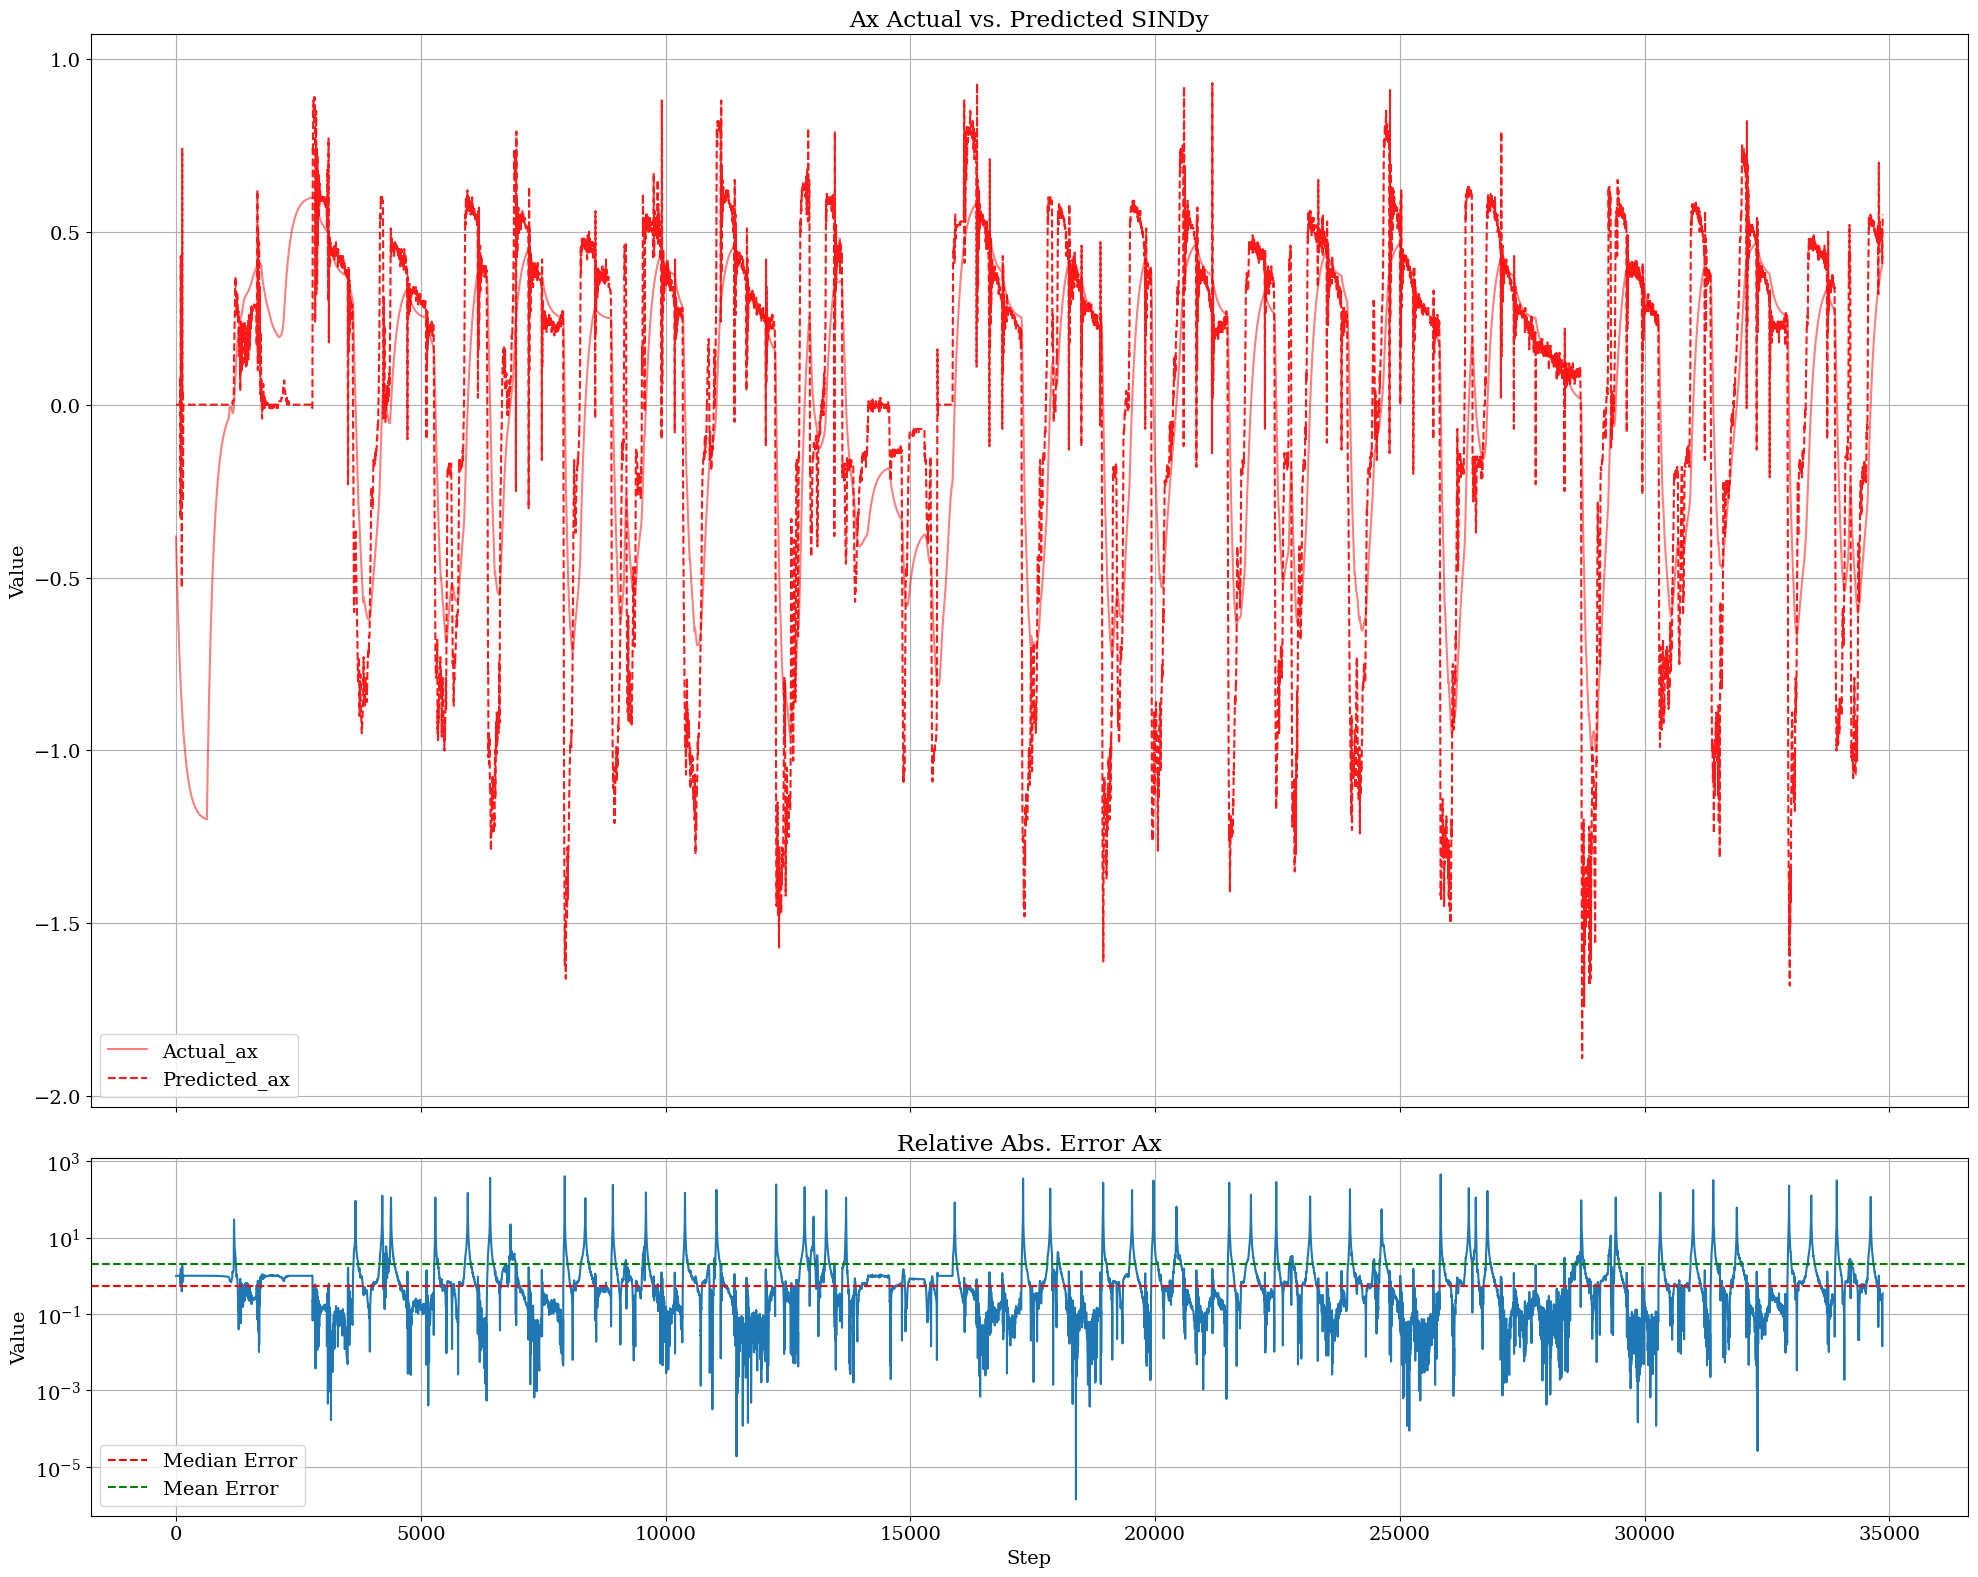


-----------------------------------------------------------------
Median Error Ay SINDy: 0.986022073148207
Mean Error Ay SINDy: 3.8413107614290127
RMSE Ay SINDy: 0.23084680232865867


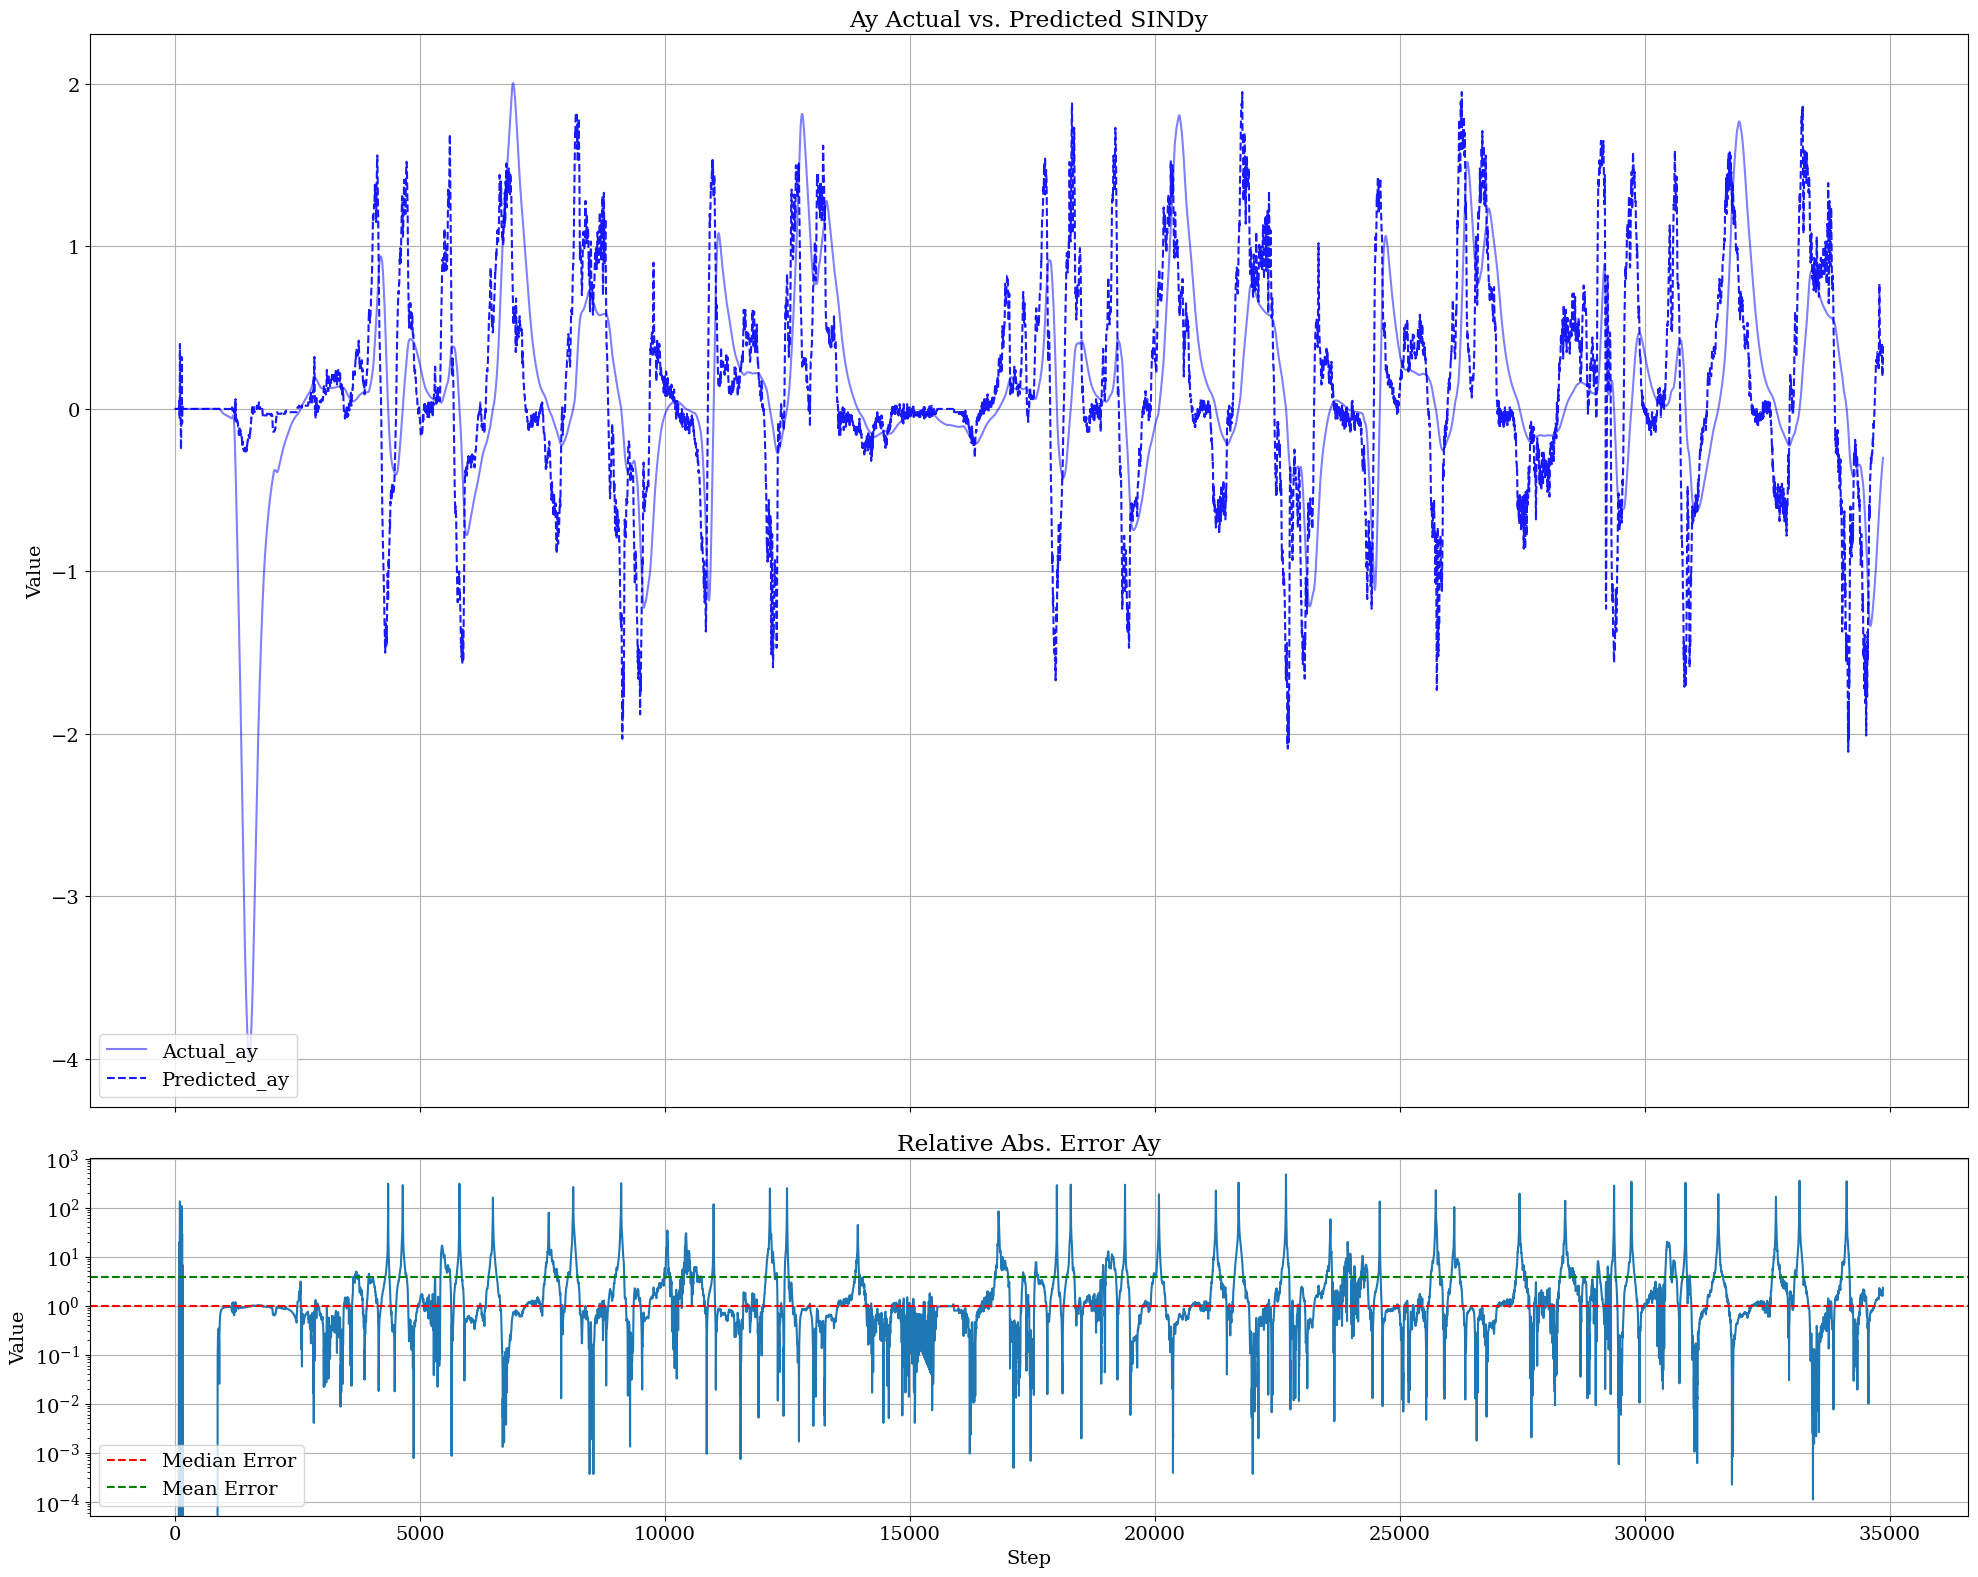


-----------------------------------------------------------------
Median Error Yaw Rate SINDy: 0.6739810752503566
Mean Error Yaw Rate SINDy: 1.452865347574411
RMSE Yaw Rate SINDy: 0.1287711915139919


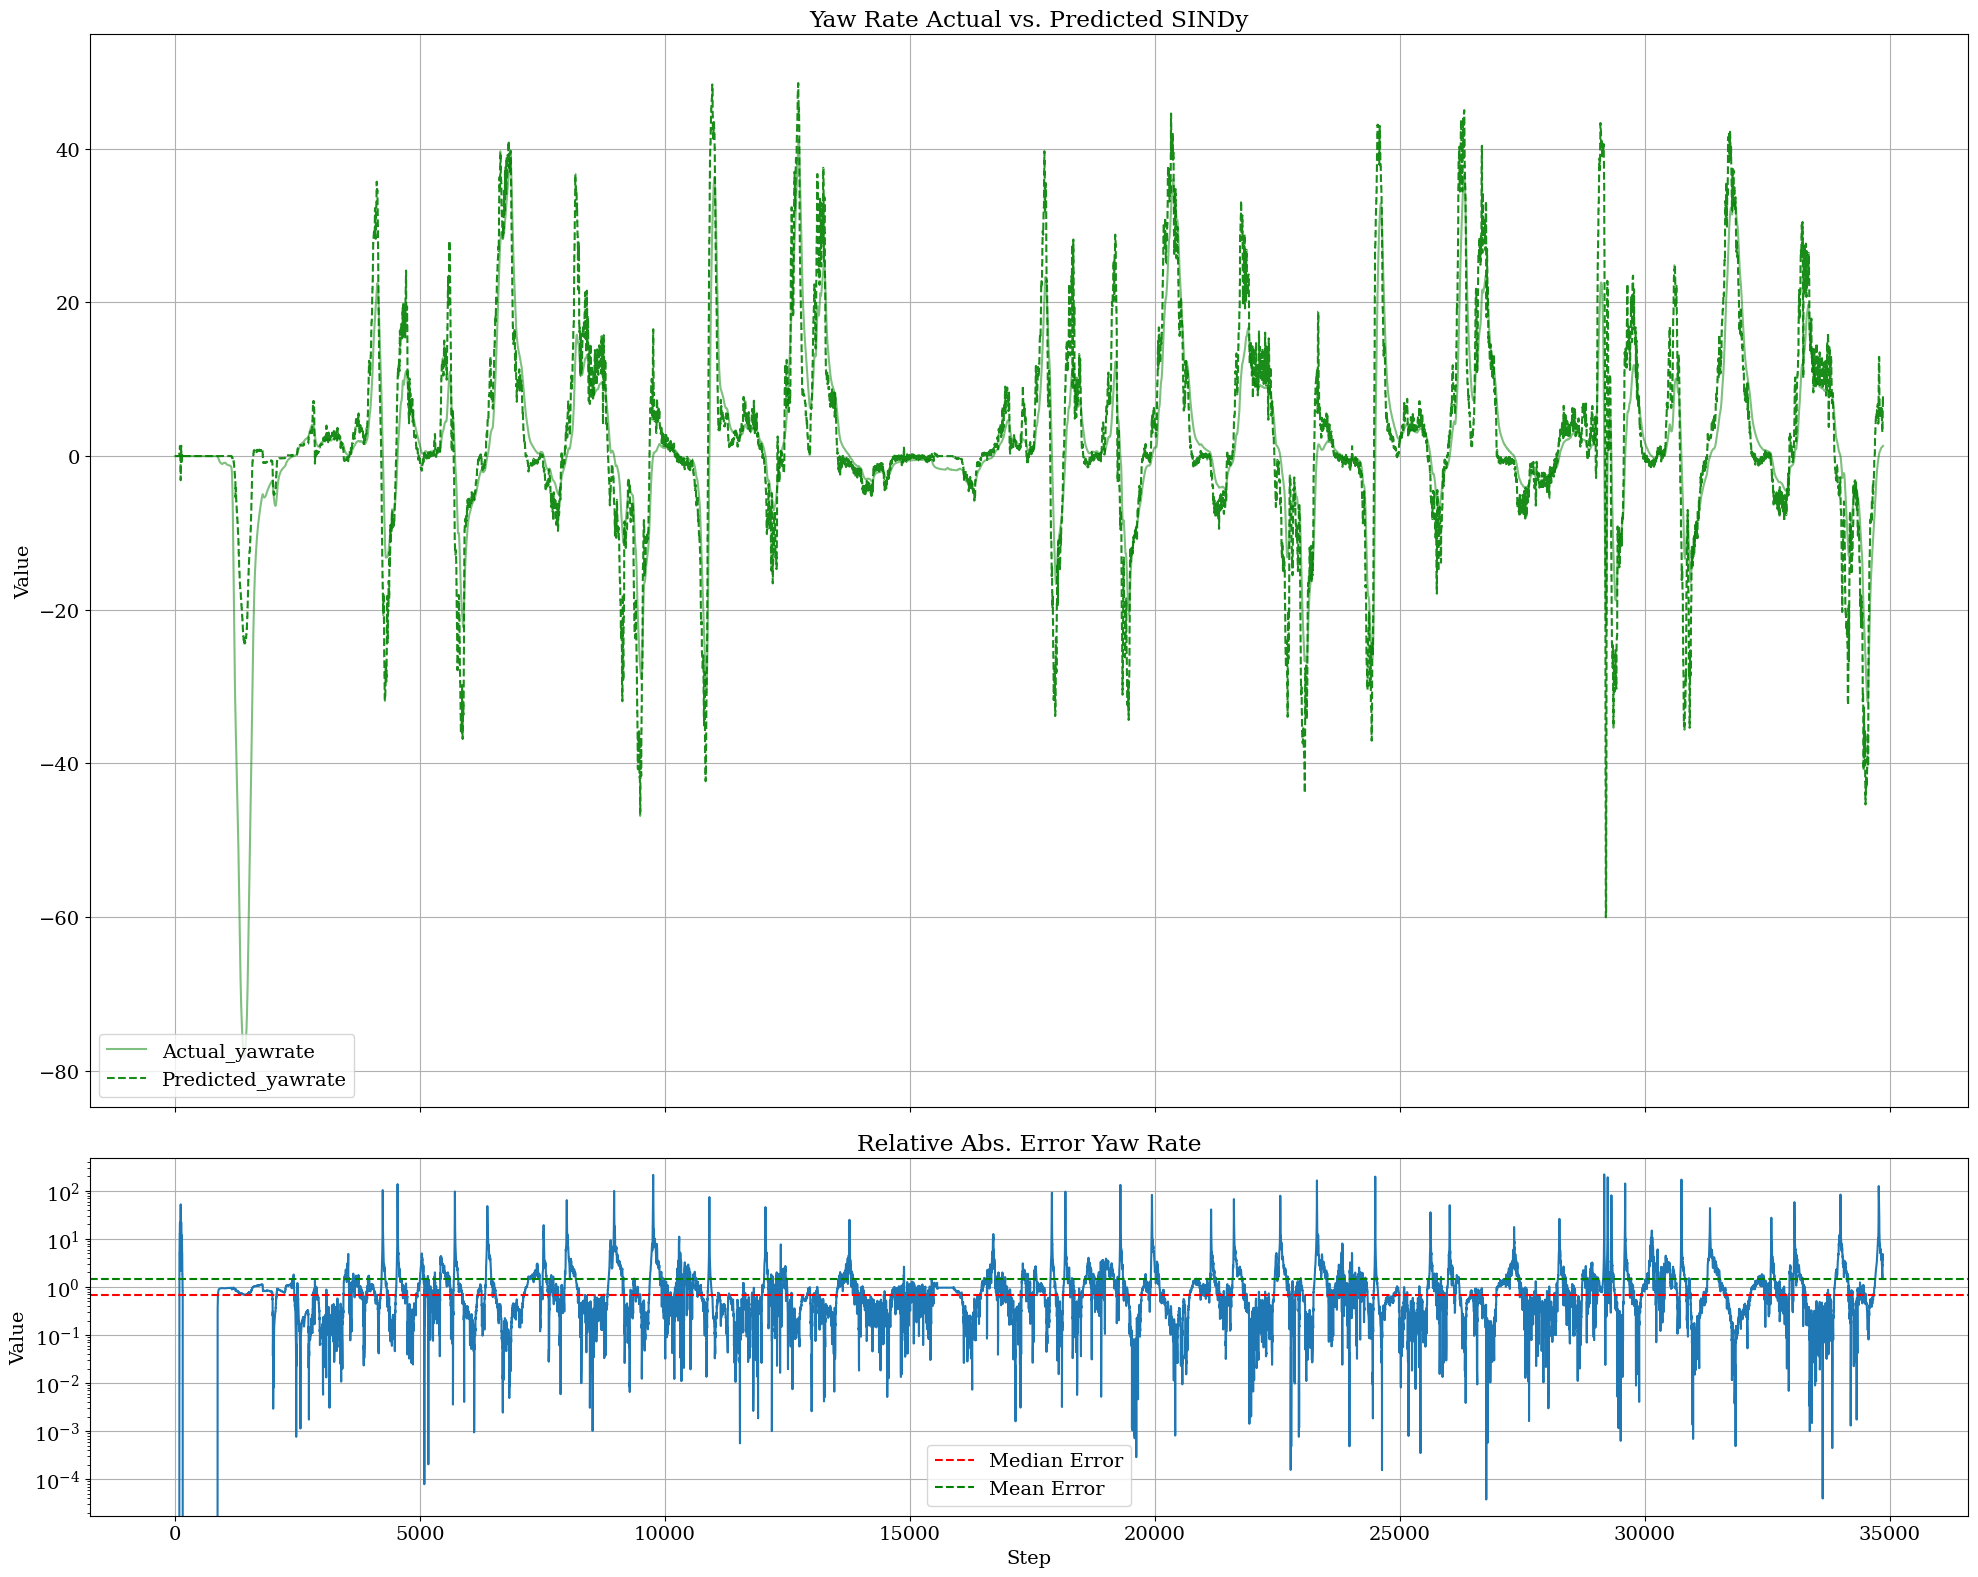


-----------------------------------------------------------------
Median Error Ax Combined: 0.20964137244708209
Mean Error Ax Combined: 7.291160761113119
RMSE Ax Combined: 0.05797145006935953


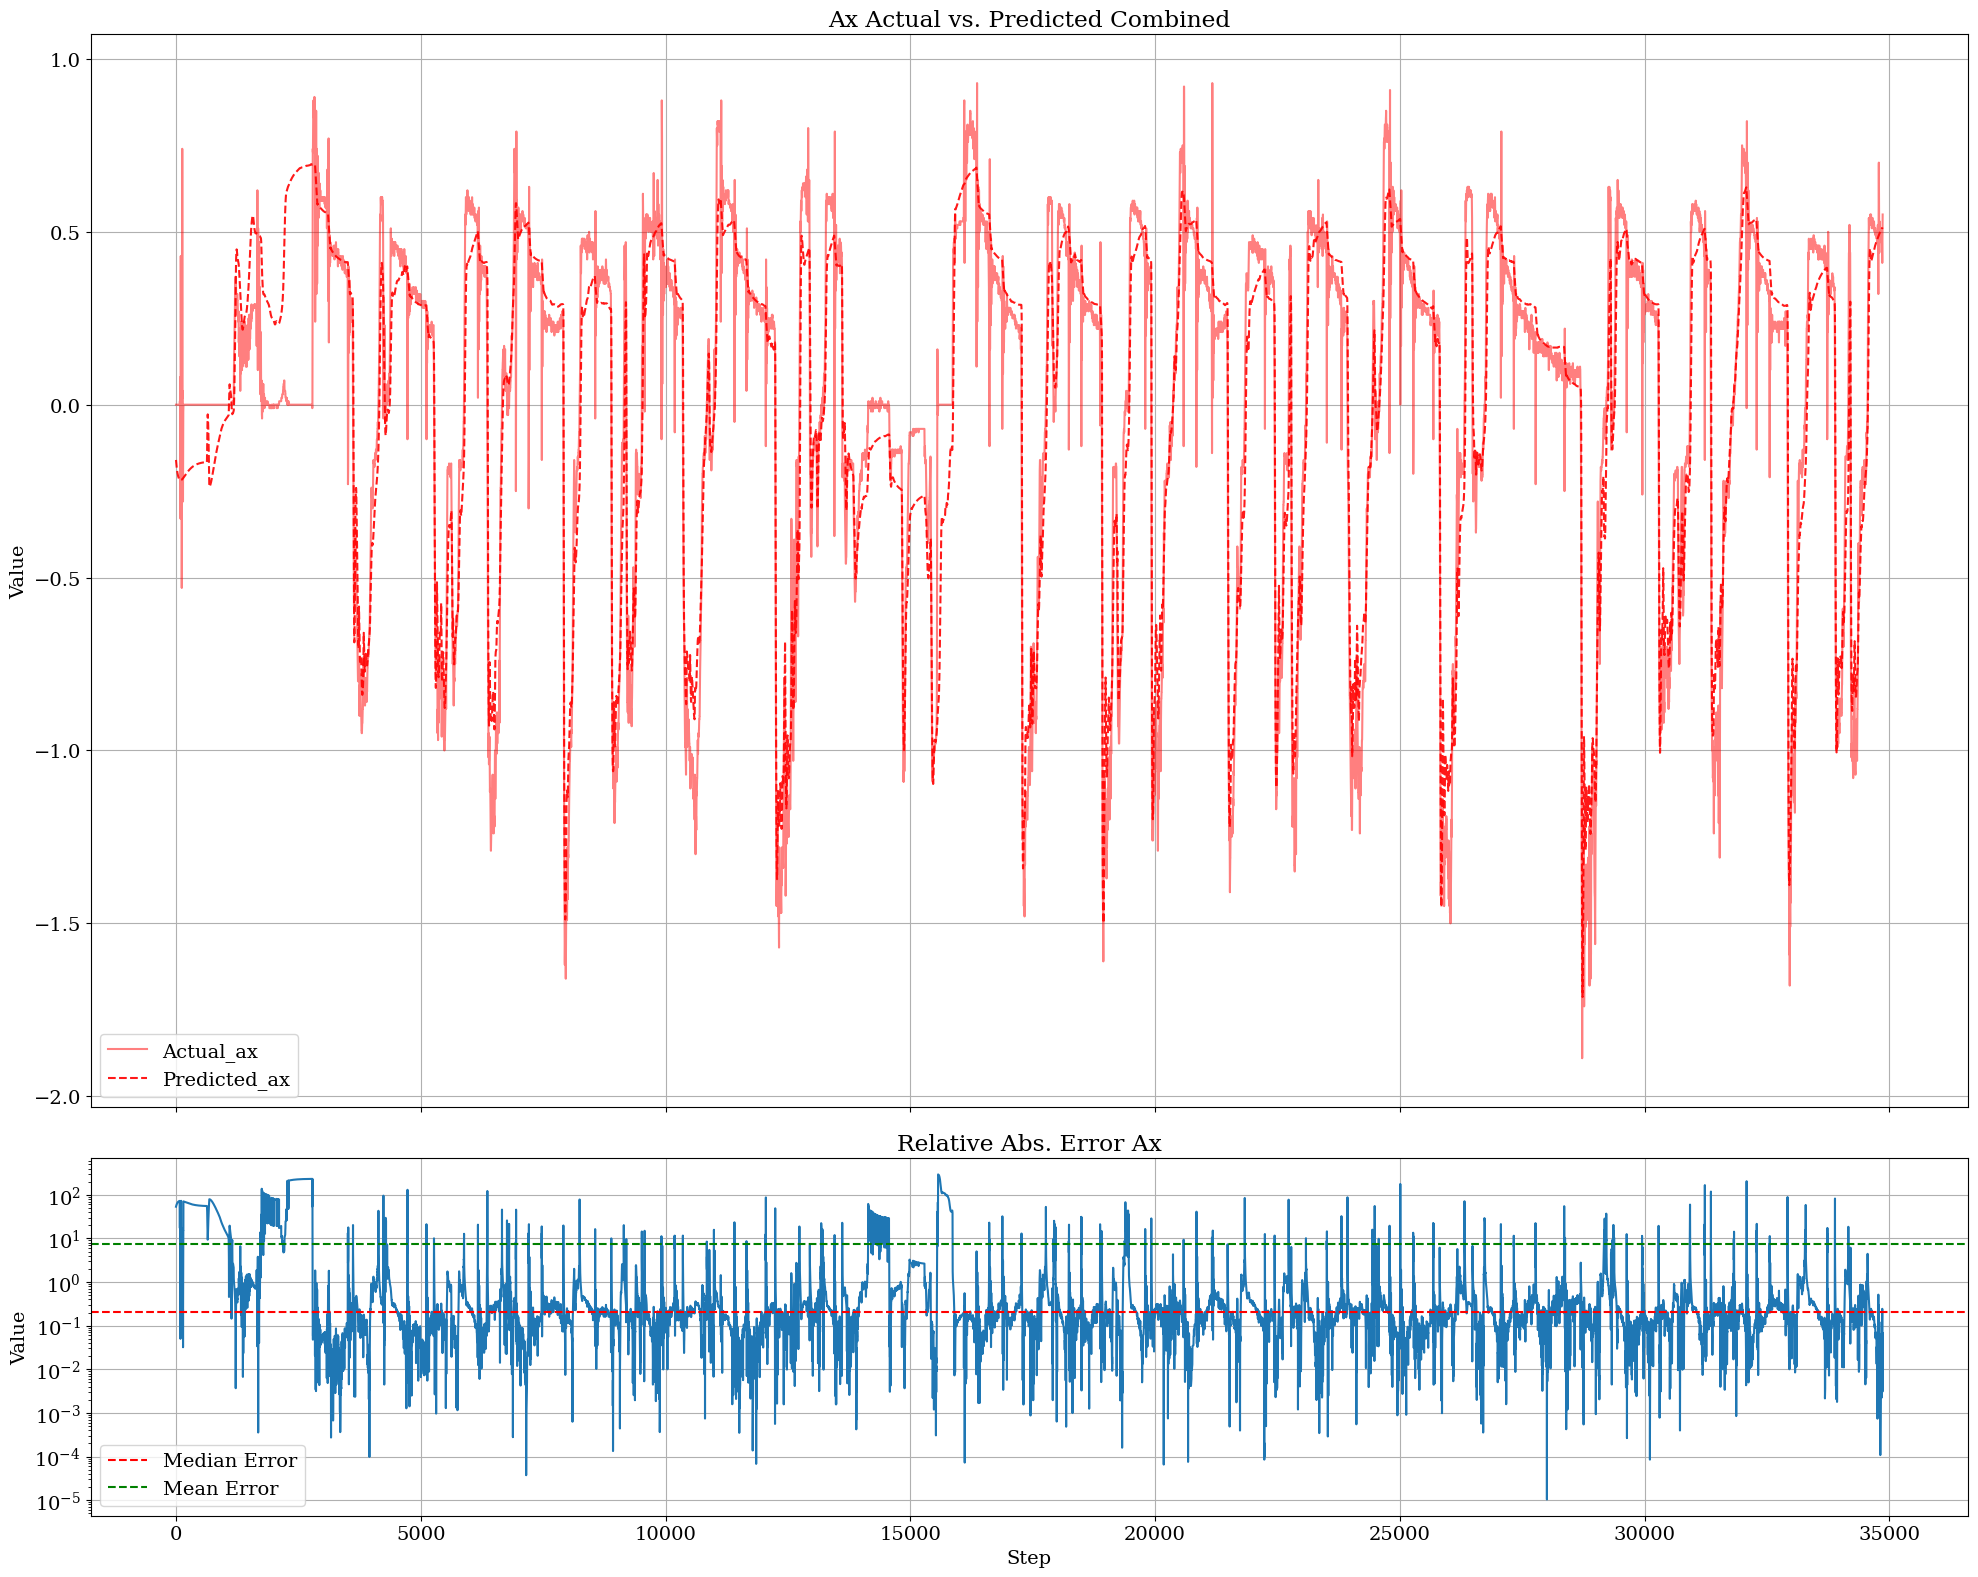


-----------------------------------------------------------------
Median Error Ay Combined: 0.43053149183333117
Mean Error Ay Combined: 2.241622779593449
RMSE Ay Combined: 0.07039466635067405


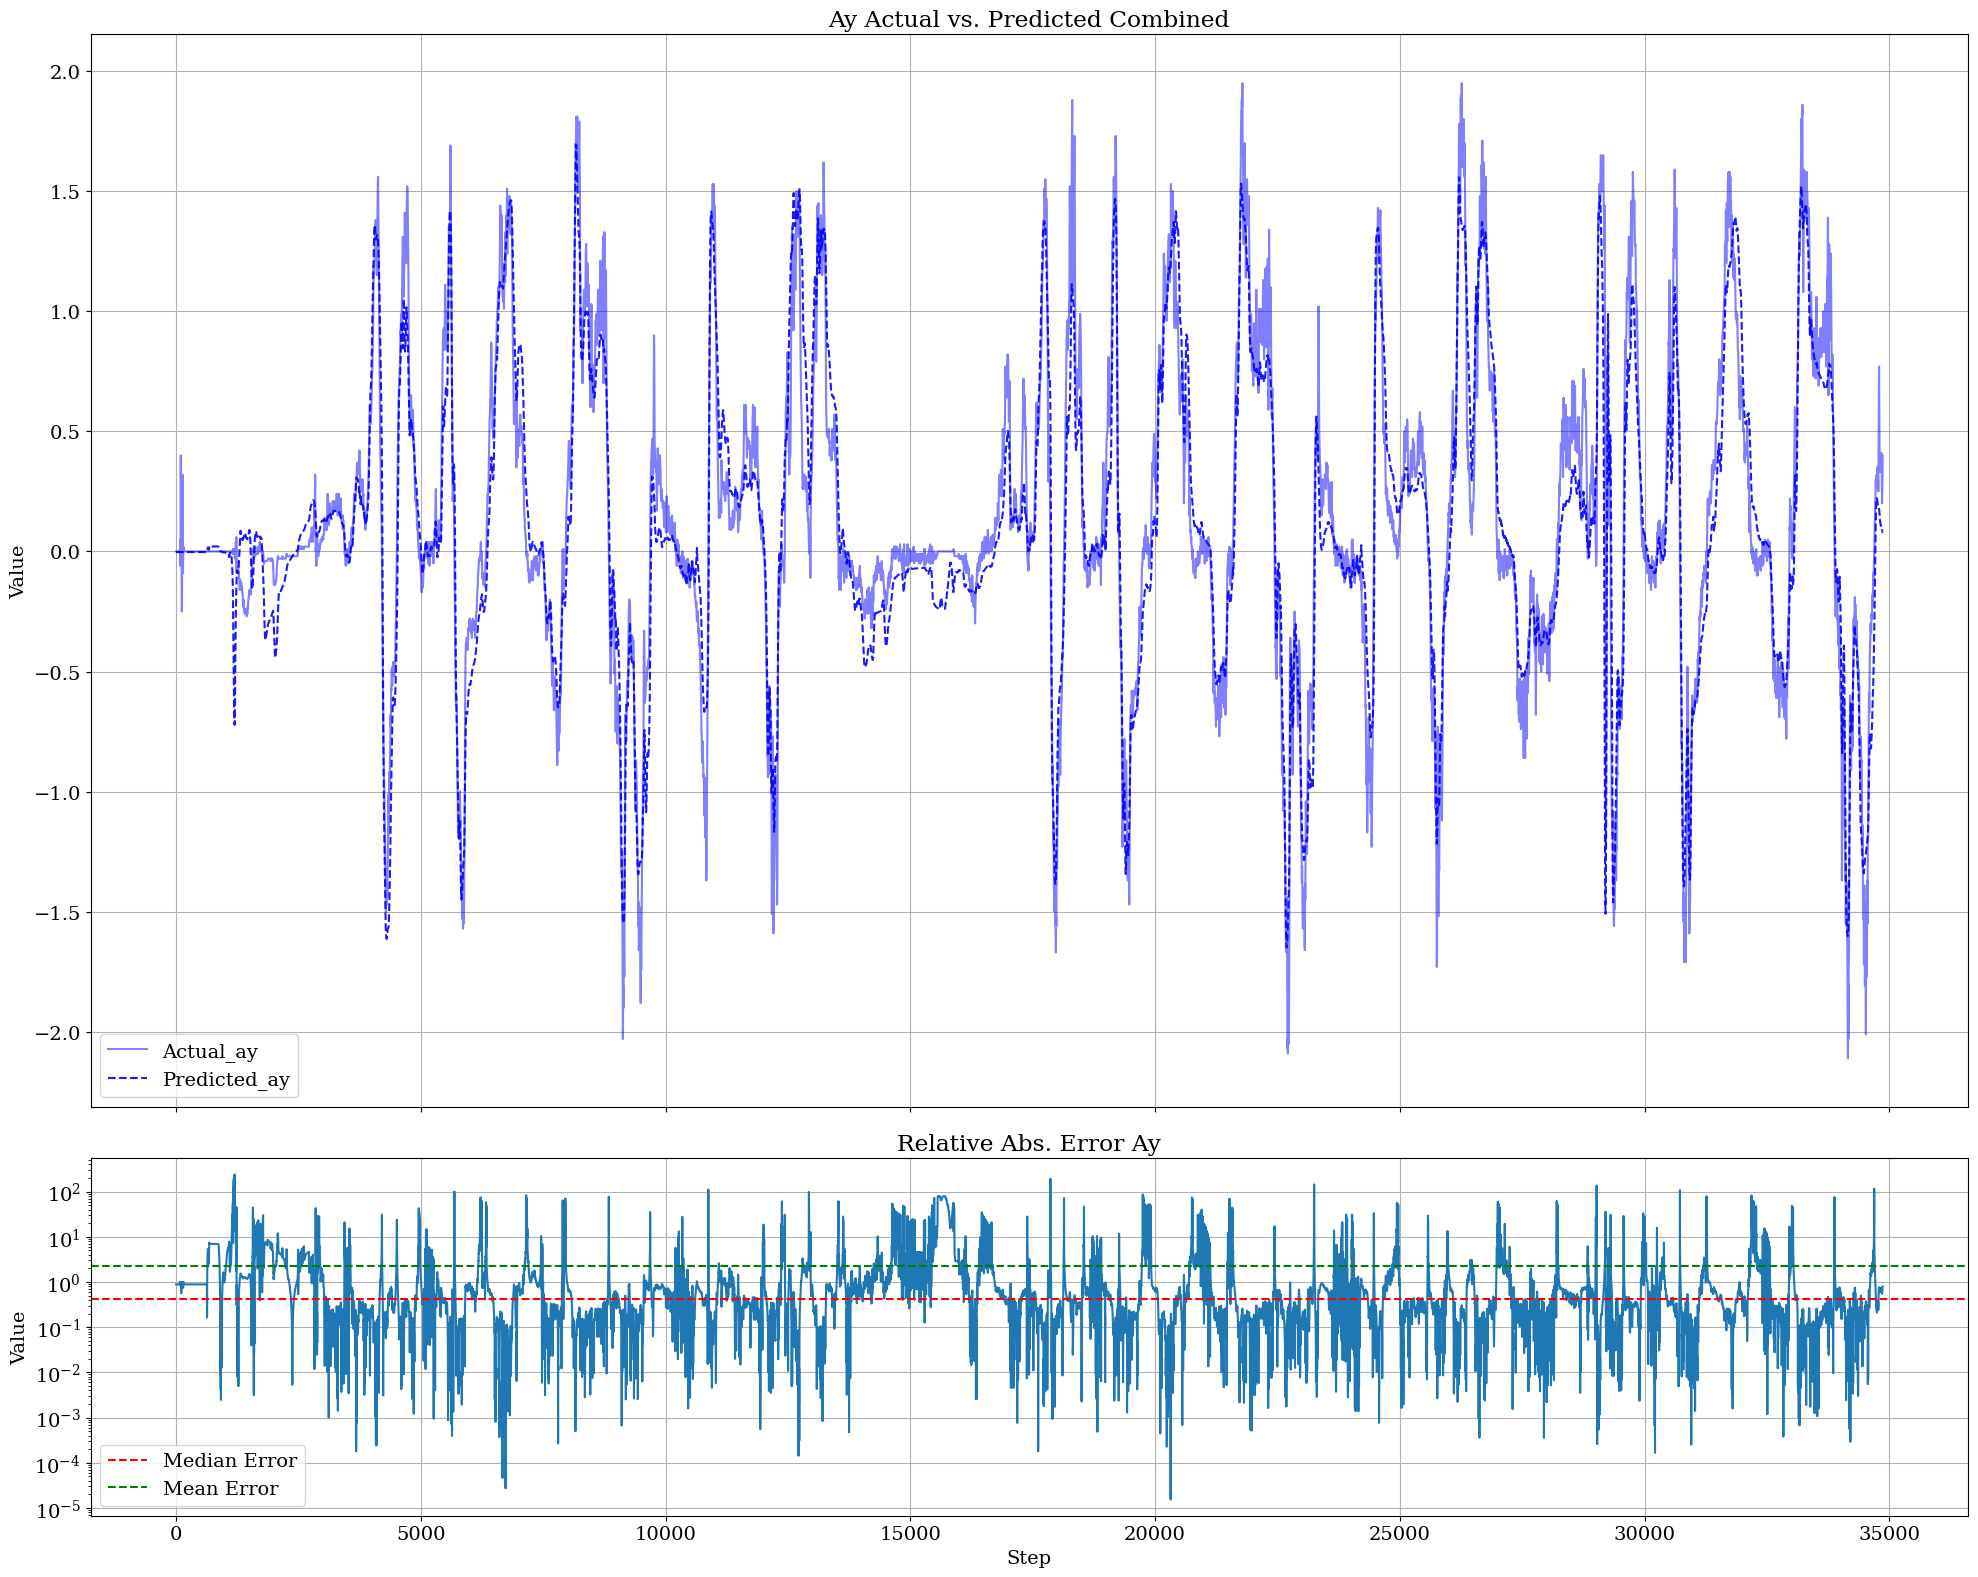


-----------------------------------------------------------------
Median Error Yaw Rate Combined: 0.30628846989184705
Mean Error Yaw Rate Combined: 1.3386129421317592
RMSE Yaw Rate Combined: 0.0630667095266721


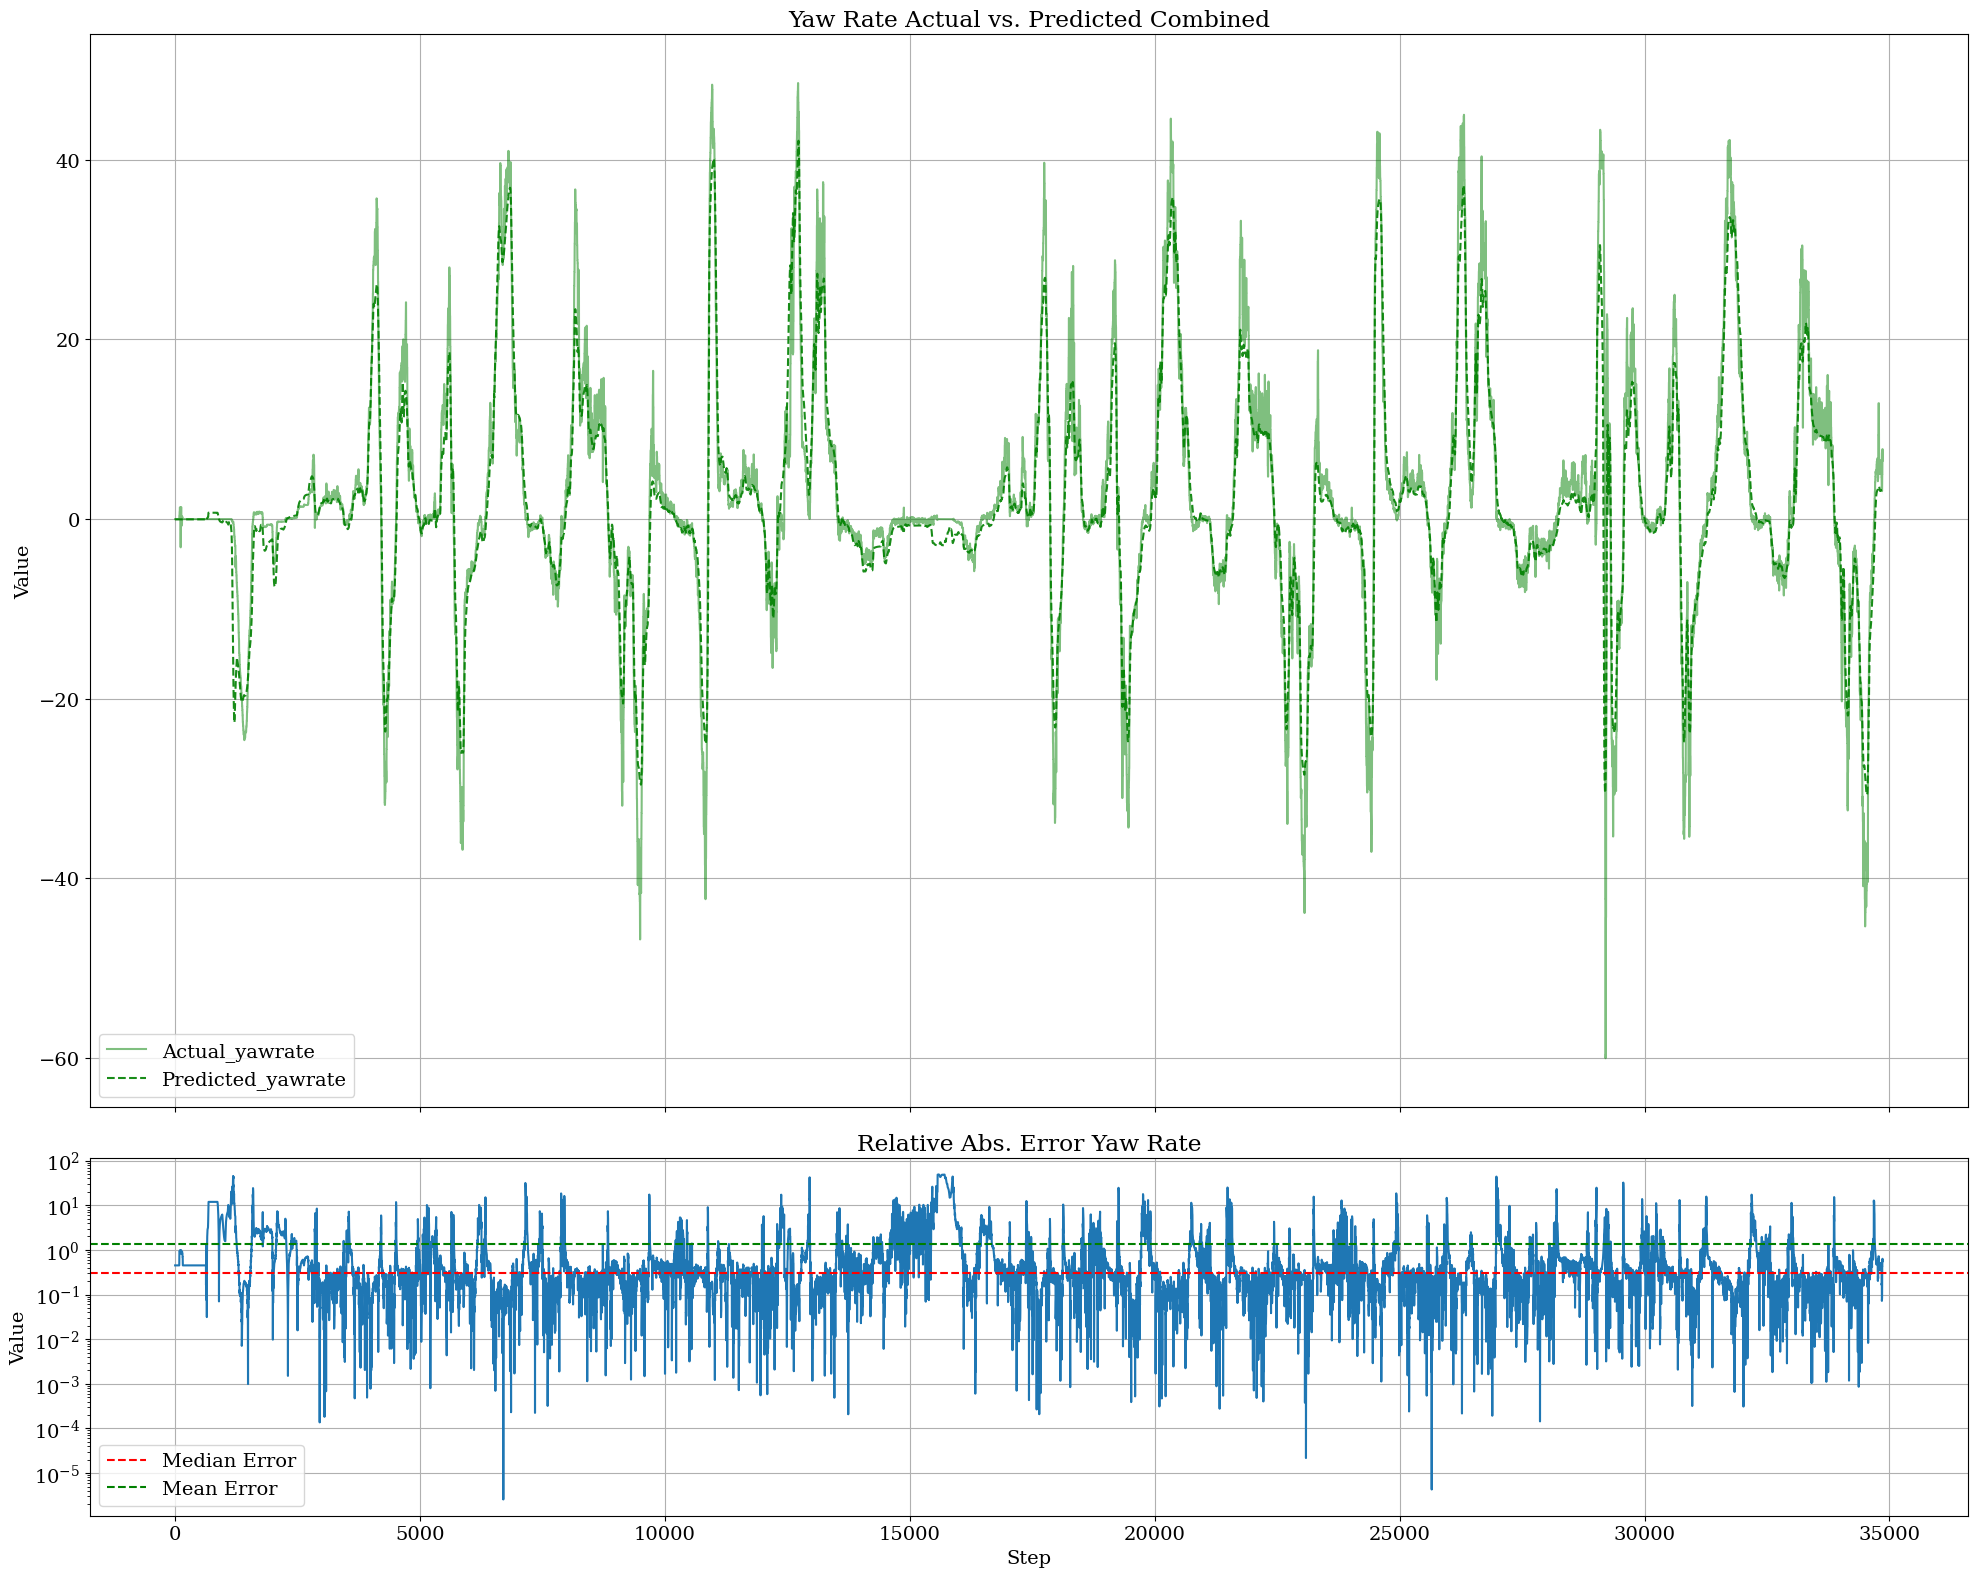

In [ ]:
# @title __4. Test and Plot Results using VeMo Methods__

# inference takes the VeMo_Net and VeMo_SINDy and perform inference and compute the Pearson windowed correlation btw SINDy and NN as an index of matching in prediction
y_pred_loaded, simulated_sindy = vemo.inference('./VeMo_Net.h5', './VeMo_SINDy.pkl', X_TEST, data_TEST)

# models_combiner merge the outputs of the two models (SINDy NN) appling a dynamic averaging based on its delta, for high discrepancy NN have more trust
# VeMo finals ouputs are the follow, so user can choose to use only NN, only SINDy or both combined, as done below
combined_estimate_ax = vemo.models_combiner( y_pred_loaded[:, 0], simulated_sindy[:, 0])
combined_estimate_ay = vemo.models_combiner( y_pred_loaded[:, 1], simulated_sindy[:, 1])
combined_estimate_yawrate = vemo.models_combiner( y_pred_loaded[:, 2], simulated_sindy[:, 2])

# Optional
# Plot to compare Models w/ True output ------------------------

vemo.plot_comparison(y_pred_loaded, y_TEST, simulated_sindy, scaling_factors) # compare NN and SINDy w/ the True Signal

combined_results = np.column_stack((combined_estimate_ax, combined_estimate_ay, combined_estimate_yawrate))
vemo.plot_combined(combined_results, y_TEST, scaling_factors) # compare combined w/ the True Signal





---



#___utils:__

In [ ]:
#@title __check colab packege versions__

#_______________________________________________________________________________
# CHECK PACKAGES VERSION:
#_______________________________________________________________________________

#import pysindy as ps

#import numpy as np
#from scipy.integrate import solve_ivp
#from sklearn.linear_model import Lasso
#from pysindy.feature_library import PolynomialLibrary, FourierLibrary, IdentityLibrary

#import numpy as np
#import pandas as pd
#import tensorflow as tf
#import keras

#from tensorflow.keras.utils  import plot_model
#from keras_self_attention import SeqSelfAttention
#from keras.models import Model
#from keras.layers import Input, GRU, Dense, Bidirectional, Concatenate, Lambda, Reshape, Add, Subtract
#from keras.initializers import GlorotUniform
#import keras.backend as K
#from keras.models import load_model
#from keras.utils import custom_object_scope

#from matplotlib import pyplot as plt
#from scipy.signal import savgol_filter
#from scipy.stats import pearsonr

#import os
#packages = [
#    'pysindy',
#    'scipy',
#    'numpy',
#    'sklearn',
#    'pandas',
#    'keras',
#    'tensorflow',
#    'matplotlib',
#    'keras_self_attention'
#]

#for package in packages:
#    try:
#        version = os.popen(f"pip show {package} | grep Version").read().strip().split(': ')[1]
#        print(f"{package}: {version}")
#    except Exception as e:
#        print(f"Error getting version for {package}: {e}")
